In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
import datetime
import csv
from scipy import stats as st
import itertools
import re 

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'/Users/samismalling/Documents/mobility-report-data-extractor-master/CovidMobile'

In [3]:
df = pd.read_csv('data/compiled_2020-04-26.csv')

In [5]:
df['peaks'] = df.groupby(['FIPS'])['cases'].transform(max)

In [6]:
df.rename(columns={'state_x':'state','county_x':'county'},inplace=True)

In [7]:
df['post_soe'] = np.where(df['date']>=df['soe'],1,0)
df['post_sah'] = np.where(df['date']>=df['sah'],1,0)

In [7]:
def t_test(pop,div,metric):
    data = pop.dropna(subset=[metric])
    s1 = data[data[div]==1][metric].copy()
    s2 = data[data[div]==0][metric].copy()
    print('What happend at {}?'.format(metric))
    print(data.groupby([div])[metric].describe())
    print("\n T-Test Results = {} (t-stat,2 sided p-values)".format(st.ttest_ind(s1,s2)))

In [8]:
for i in ['retail','food_drugs','park','transit','work','homes']:
    t_test(df,'post_soe',i)
    t_test(df,'post_sah',i)

What happend at retail?
            count       mean        std    min   25%   50%   75%    max
post_soe                                                               
0         58686.0   8.300770  11.339559  -85.0   2.0   8.0  14.0  153.0
1         74764.0 -24.533893  21.916760 -100.0 -40.0 -29.0  -9.0  226.0

 T-Test Results = Ttest_indResult(statistic=-329.9193674842295, pvalue=0.0) (t-stat,2 sided p-values)
What happend at retail?
             count       mean        std    min   25%   50%   75%    max
post_sah                                                                
0         106898.0  -2.668759  20.522768 -100.0 -16.0   3.0  11.0  226.0
1          26552.0 -39.990509  12.659732 -100.0 -47.0 -40.0 -32.0   86.0

 T-Test Results = Ttest_indResult(statistic=-283.24546164254934, pvalue=0.0) (t-stat,2 sided p-values)
What happend at food_drugs?
            count      mean        std   min   25%  50%   75%    max
post_soe                                                            

In [8]:
prez = pd.read_csv("data/countypres_2000-2016.csv")

In [10]:
prez.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208,20191203
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203


In [9]:
prez['vote_share']= prez['candidatevotes'] / prez['totalvotes']
prez['vote_share'].describe()

count    50120.000000
mean         0.314603
std          0.264512
min          0.000000
25%          0.022464
50%          0.327248
75%          0.539318
max          0.960334
Name: vote_share, dtype: float64

In [10]:
prez['max'] = prez.groupby(['FIPS','year'])['candidatevotes'].transform(max)

prez_win = prez[prez['max']==prez['candidatevotes']].copy()
prez_win = pd.concat([prez_win.reset_index(),prez[prez['party']=='republican']['vote_share'].rename('vote_share_rep').reset_index()],axis=1)

In [11]:
prez_win.head()

,index,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version,vote_share,max,index,vote_share_rep
0,1.0,2000.0,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208.0,20191203.0,0.696943,11993.0,1,0.696943
1,5.0,2000.0,Alabama,AL,Baldwin,1003.0,President,George W. Bush,republican,40872.0,56480.0,20191203.0,0.723654,40872.0,5,0.723654
2,8.0,2000.0,Alabama,AL,Barbour,1005.0,President,Al Gore,democrat,5188.0,10395.0,20191203.0,0.499086,5188.0,9,0.490236
3,13.0,2000.0,Alabama,AL,Bibb,1007.0,President,George W. Bush,republican,4273.0,7101.0,20191203.0,0.601746,4273.0,13,0.601746
4,17.0,2000.0,Alabama,AL,Blount,1009.0,President,George W. Bush,republican,12667.0,17973.0,20191203.0,0.704779,12667.0,17,0.704779


In [12]:
prez_win.sort_values(by=['FIPS','year'],inplace=True)
for i in list(range(1,5,1)):
    shifted =prez_win.groupby(['FIPS'])['candidate','party','candidatevotes','totalvotes','vote_share_rep'].shift(i)
    prez_win = prez_win.join(shifted.rename(columns=lambda x: x+"_{}".format(i)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
prez_win = prez_win[prez_win['party_4'].notnull()].copy() 

In [14]:
prez_win.columns

Index(['index', 'year', 'state', 'state_po', 'county', 'FIPS', 'office',
       'candidate', 'party', 'candidatevotes', 'totalvotes', 'version',
       'vote_share', 'max', 'index', 'vote_share_rep', 'candidate_1',
       'party_1', 'candidatevotes_1', 'totalvotes_1', 'vote_share_rep_1',
       'candidate_2', 'party_2', 'candidatevotes_2', 'totalvotes_2',
       'vote_share_rep_2', 'candidate_3', 'party_3', 'candidatevotes_3',
       'totalvotes_3', 'vote_share_rep_3', 'candidate_4', 'party_4',
       'candidatevotes_4', 'totalvotes_4', 'vote_share_rep_4'],
      dtype='object')

In [15]:
conditions = [
    (prez_win['party']=='republican')&((prez_win['party_1']=='democrat')|(prez_win['party_2']=='democrat')),
    (prez_win['party']=='republican')&(prez_win['party_1']=='republican')&(prez_win['party_2']=='republican'),
    (prez_win['party']=='democrat')&(prez_win['party_1']=='democrat')&(prez_win['party_2']=='democrat'),
    (prez_win['party']=='democrat')&((prez_win['party_1']=='republican')|(prez_win['party_2']=='republican')),
]
vals =['flip_trump','stay_trump','stay_hill','flip_hill']


In [16]:
prez_win['results'] =  np.select(conditions, vals, default='miss')

In [17]:
prez_win['FIPS'] = np.where(prez_win['state_po'] == 'DC',11000.0,prez_win['FIPS'])

In [18]:
prez_win[prez_win['FIPS'] == 12003]

,index,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,...,party_3,candidatevotes_3,totalvotes_3,vote_share_rep_3,candidate_4,party_4,candidatevotes_4,totalvotes_4,vote_share_rep_4,results
12746,41394.0,2016.0,Florida,FL,Baker,12003.0,President,Donald Trump,republican,10294.0,...,republican,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump


In [19]:
df_tog = df.merge(prez_win,on=['FIPS'],how='left')

In [20]:
df_tog['turnout_pct'] = df_tog['totalvotes'] / df_tog['POP_ESTIMATE_2016']
df_tog['turnout_pct'].describe()
df_tog[df_tog['turnout_pct'] == df_tog['turnout_pct'].max()][['FIPS','county_x','candidatevotes','totalvotes','POP_ESTIMATE_2016']]

,FIPS,county_x,candidatevotes,totalvotes,POP_ESTIMATE_2016
14595,8091.0,Ouray County,1697.0,3310.0,4788.0
14596,8091.0,Ouray County,1697.0,3310.0,4788.0
14597,8091.0,Ouray County,1697.0,3310.0,4788.0
14598,8091.0,Ouray County,1697.0,3310.0,4788.0
14599,8091.0,Ouray County,1697.0,3310.0,4788.0


In [21]:
# Washington DC
df_tog = df_tog[(df_tog['geo']=='county')|(df_tog['FIPS']==11000)].copy()
df_tog.geo.value_counts()
df_tog[df_tog['FIPS']==12003]

,country_region_code,country_region,state_x,county_x,date,retail,food_drugs,park,transit,work,...,candidatevotes_3,totalvotes_3,vote_share_rep_3,candidate_4,party_4,candidatevotes_4,totalvotes_4,vote_share_rep_4,results,turnout_pct
16171,US,United States,Florida,Baker County,2020-02-15,4.0,9.0,NaN,NaN,-1.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16172,US,United States,Florida,Baker County,2020-02-16,0.0,-6.0,NaN,NaN,-7.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16173,US,United States,Florida,Baker County,2020-02-17,3.0,6.0,NaN,NaN,-25.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16174,US,United States,Florida,Baker County,2020-02-18,1.0,9.0,NaN,NaN,0.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16175,US,United States,Florida,Baker County,2020-02-19,7.0,7.0,NaN,NaN,0.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16176,US,United States,Florida,Baker County,2020-02-20,0.0,6.0,NaN,NaN,0.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16177,US,United States,Florida,Baker County,2020-02-21,3.0,6.0,NaN,NaN,-3.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16178,US,United States,Florida,Baker County,2020-02-22,1.0,11.0,NaN,NaN,-5.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16179,US,United States,Florida,Baker County,2020-02-23,6.0,-1.0,NaN,NaN,-4.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286
16180,US,United States,Florida,Baker County,2020-02-24,4.0,15.0,NaN,NaN,0.0,...,7738.0,9955.0,0.385472,George W. Bush,republican,5610.0,8154.0,0.688006,stay_trump,0.453286


# Models

In [24]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels as sm
from statsmodels.iolib.summary2 import summary_col


### Model Specification
 Mobility(i,t,s) =Republican(i) + Controls(i) + State(s) + Time(t)
 <br>
 <br>i=county
 <br>t=time
 <br>s=state
  <br>
 <br>Republican  = dummy for the district voted republican
 <br>Controls = County's income, employment, population, etc. 
 <br>State = Indicator for the state
 <br>Time = Indicator for the day


## Data Transformations

In [33]:
usda = pd.read_csv('./data/clean_usda2.csv')

#Select certain variables to add into model:
usda_vars = ['FIPS','PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15','GROC14','SUPERC14','CONVS14','SPECS14',
            'PCT_SNAP16','FOODINSEC_13_15']
usda = usda[usda_vars]
#combine num grocery stores, supserstores, convenience stores and specialty food stores into totalstores
usda['total stores'] = usda['GROC14']+ usda['SUPERC14']+ usda['CONVS14']+ usda['SPECS14']

#rename columns:
newcols = ['FIPS','perc_pop_low_access15', 'perc_low_access_low_income15', 'grocery14', 'superstores14', 
           'convenience14', 'specialized14', 'perc_SNAP16', 'perc_food_insecure1315','total_stores']
d = {}
for i in range(len(newcols)):
    d[list(usda.columns)[i]] = newcols[i]
    
usda.rename(columns = d, inplace = True)

usda.head()

,FIPS,perc_pop_low_access15,perc_low_access_low_income15,grocery14,superstores14,convenience14,specialized14,perc_SNAP16,perc_food_insecure1315,total_stores
0,1001,32.062255,11.991125,4.0,1.0,30.0,2.0,16.976436,17.6,37.0
1,1003,16.767489,5.424427,29.0,6.0,118.0,26.0,16.976436,17.6,179.0
2,1005,22.105560,10.739667,5.0,1.0,19.0,2.0,16.976436,17.6,27.0
3,1007,4.230324,2.601627,5.0,1.0,15.0,1.0,16.976436,17.6,22.0
4,1009,6.497380,2.880150,6.0,1.0,27.0,0.0,16.976436,17.6,34.0


In [83]:
df_tog['date'] =pd.to_datetime(df_tog['date'],errors='coerce')
df_tog.results = df_tog.results.astype('category')
df_tog["partisan_cat"] = df_tog["results"].cat.codes
df_tog['dow'] = df_tog['date'].dt.dayofweek
df_tog['vote_share_rep_avg'] = (df_tog['vote_share_rep'] + df_tog['vote_share_rep_1'] + df_tog['vote_share_rep_2']) / 3
dow_dumms = pd.get_dummies(df_tog.dow)
dow = dow_dumms.columns.values
state_dumms = pd.get_dummies(df_tog.state_abb_x)
states = state_dumms.columns.values
day_dumms = pd.get_dummies(df_tog['date'].dt.date)
print(len(day_dumms.columns))
day_dumms.columns = ['day' + str(i) for i in list(range(0,len(day_dumms.columns)))]
days = day_dumms.columns.values

df_fin = pd.concat([df_tog,pd.get_dummies(df_tog['party']),state_dumms,dow_dumms,day_dumms],axis=1)
df_fin.rename(columns={'Percent of adults with less than a high school diploma, 2014-18':'pct_less_hs',
       'Percent of adults with a high school diploma only, 2014-18':'pct_only_hs',
       "Percent of adults completing some college or associate's degree, 2014-18":'pct_some_co',
       "Percent of adults with a bachelor's degree or higher, 2014-18":'pct_has_co'}, inplace=True)
df_fin = df_fin.merge(usda,on=['FIPS'],how='left')
extra_controls = ['ln_total_stores','perc_pop_low_access15','pct_less_hs','pct_only_hs','pct_some_co','PCTPOVALL_2018']
df_fin['ln_pop'] = df_fin['POP_ESTIMATE_2018'].apply(np.log)
df_fin['ln_income'] = df_fin['Median_Household_Income_2018'].apply(np.log)
df_fin['ln_employed'] = df_fin['Employed_2018'].apply(np.log)
df_fin['ln_unemployed'] = df_fin['Unemployed_2018'].apply(np.log)
df_fin['ln_total_stores'] = df_fin['total_stores'].apply(np.log)
df_fin['obs'] = 1
df_fin = df_fin.dropna(subset= ['party'])
df_fin = df_fin[(df_fin['results']=='stay_trump')|(df_fin['results']=='stay_hill')].copy()
df_fin['vote_share_q'] = pd.qcut(df_fin['vote_share_rep'],5,labels=[1,2,3,4,5])
print(df_fin.shape)
df_fin['nomiss_3'] = np.where( df_fin[['retail','food_drugs','work']].isnull().any(axis=1),0,1)
df_fin['nomiss_5'] = np.where( df_fin[['retail','food_drugs','work','transit','homes']].isnull().any(axis=1),0,1)
df_fin['consecutive_days_nomiss_3'] = df_fin.groupby(['FIPS','nomiss_3'])['obs'].transform(sum)
df_fin['consecutive_days_nomiss_5'] = df_fin.groupby(['FIPS','nomiss_5'])['obs'].transform(sum)
df_fin.sort_values(by=['FIPS','date'],inplace=True)
df_fin['time_trend'] = df_fin.groupby(['date']).cumcount()

57
(129881, 282)


In [84]:
df_fin.drop_duplicates(subset=['FIPS'])[['total_stores','perc_pop_low_access15','PCTPOVALL_2018']].corr()

,total_stores,perc_pop_low_access15,PCTPOVALL_2018
total_stores,1.000000,-0.025827,-0.080314
perc_pop_low_access15,-0.025827,1.000000,-0.028946
PCTPOVALL_2018,-0.080314,-0.028946,1.000000


In [85]:
df_fin[['total_stores','retail']].corr()

,total_stores,retail
total_stores,1.0000,-0.0973
retail,-0.0973,1.0000


In [86]:
df_fin.groupby(['FIPS'])['total_stores'].describe()

,count,mean,std,min,25%,50%,75%,max
FIPS,,,,,,,,
1001.0,57.0,37.0,0.0,37.0,37.0,37.0,37.0,37.0
1003.0,57.0,179.0,0.0,179.0,179.0,179.0,179.0,179.0
1007.0,57.0,22.0,0.0,22.0,22.0,22.0,22.0,22.0
1009.0,57.0,34.0,0.0,34.0,34.0,34.0,34.0,34.0
1011.0,56.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...
56037.0,57.0,29.0,0.0,29.0,29.0,29.0,29.0,29.0
56039.0,57.0,36.0,0.0,36.0,36.0,36.0,36.0,36.0
56041.0,57.0,18.0,0.0,18.0,18.0,18.0,18.0,18.0


(86321, 287) 114        1001.0
115        1001.0
116        1001.0
117        1001.0
118        1001.0
           ...   
152058    56037.0
152059    56037.0
152060    56037.0
152061    56037.0
152062    56037.0
Name: FIPS, Length: 54834, dtype: float64


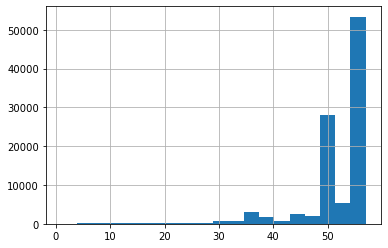

In [87]:
df_fin[(df_fin['nomiss_3']==1)]['consecutive_days_nomiss_3'].hist(bins=20)
print(df_fin[(df_fin['consecutive_days_nomiss_3']>=50) & (df_fin['nomiss_3']==1)].shape,df_fin[df_fin['consecutive_days_nomiss_3']==57]['FIPS'])

(27044, 287) 114        1001.0
115        1001.0
116        1001.0
117        1001.0
118        1001.0
           ...   
152172    56041.0
152173    56041.0
152174    56041.0
152175    56041.0
152176    56041.0
Name: FIPS, Length: 85899, dtype: float64


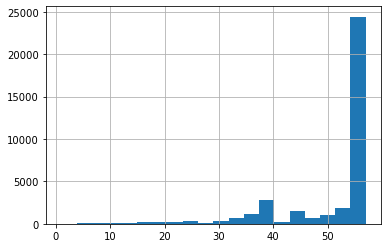

In [88]:
df_fin[(df_fin['nomiss_5']==1)]['consecutive_days_nomiss_5'].hist(bins=20)
print(df_fin[(df_fin['nomiss_5']==1)&(df_fin['consecutive_days_nomiss_5']>=50)].shape,df_fin[df_fin['consecutive_days_nomiss_5']==57]['FIPS'])

In [89]:
conditions = [
        (df_fin['nomiss_3']==1)&(df_fin['consecutive_days_nomiss_3']>=50),
    (df_fin['nomiss_5']==1)&(df_fin['consecutive_days_nomiss_5']>=50)
]
vals =['no_miss_days_3','no_miss_days_5']
for i,x in list(zip(conditions,vals)):
    df_fin[x]=np.where(i,1,0)



In [90]:
df_fin[['retail','food_drugs','transit','work','homes','park']].describe()

,retail,food_drugs,transit,work,homes,park
count,111138.000000,108100.000000,48957.000000,121858.000000,58202.000000,32168.000000
mean,-9.523313,2.638945,-9.978532,-15.676993,6.607196,10.986788
std,23.915993,15.188076,23.603459,19.193197,8.460815,39.546120
min,-100.000000,-74.000000,-91.000000,-80.000000,-7.000000,-90.000000
25%,-30.000000,-6.000000,-24.000000,-32.000000,0.000000,-14.000000
50%,-2.000000,3.000000,-4.000000,-11.000000,2.000000,8.000000
75%,9.000000,11.000000,6.000000,2.000000,14.000000,31.000000
max,187.000000,171.000000,222.000000,43.000000,38.000000,256.000000


In [91]:
for lst in ['obs','nomiss_3','nomiss_5']:
    for x in ['retail','food_drugs','transit','work','homes','park']:
        print('Sample {} non missing {} -> county count {} number of republican counties {} '.format(lst,x,df_fin[(df_fin[lst]==1)&(df_fin[x].notnull())].drop_duplicates(subset=['FIPS']).shape[0],df_fin[(df_fin[lst]==1)&(df_fin[x].notnull())].drop_duplicates(subset=['FIPS'])['republican'].sum()))
     

Sample obs non missing retail -> county count 2203 number of republican counties 1771 
Sample obs non missing food_drugs -> county count 2130 number of republican counties 1697 
Sample obs non missing transit -> county count 973 number of republican counties 661 
Sample obs non missing work -> county count 2370 number of republican counties 1921 
Sample obs non missing homes -> county count 1332 number of republican counties 1000 
Sample obs non missing park -> county count 810 number of republican counties 523 
Sample nomiss_3 non missing retail -> county count 2041 number of republican counties 1623 
Sample nomiss_3 non missing food_drugs -> county count 2041 number of republican counties 1623 
Sample nomiss_3 non missing transit -> county count 927 number of republican counties 622 
Sample nomiss_3 non missing work -> county count 2041 number of republican counties 1623 
Sample nomiss_3 non missing homes -> county count 1329 number of republican counties 997 
Sample nomiss_3 non mis

# Checking Time Trend Bias

In [58]:
df_check = df_fin[['FIPS','date','no_miss_days_3','no_miss_days_5','retail','food_drugs','transit','work','homes','obs']+list(states)+list(days)].copy()
df_check.sort_values(by=['FIPS','date'],inplace=True)
df_check['time_trend'] = df_check.groupby(['FIPS']).cumcount()
for i in [1,7]:
    print(i)
    shifted =df_check.groupby(['FIPS'])['retail','food_drugs','transit','work','homes'].shift(i)
    df_check = df_check.join(shifted.rename(columns=lambda x: x+"_t{}".format(i)))
res = []
models = []
for y in ['retail','food_drugs','transit','work','homes']:
    for val in [1,7]:
        for s in ['obs','no_miss_days_3','no_miss_days_5']:
            strng = '{} ~ '.format(y) + '{}_t{} + time_trend + '.format(y,str(val)) + ' + '.join([str(i) for i in list(states) + list(days)])
            mod = smf.ols(strng,data=df_check[df_check[s]==1])
            print(s,y,val)
            fitted = mod.fit(cov_type='HC1', return_type='dataframe')
            res.extend([fitted])
            title = 'Sample={}\nLHS={}\nRHS={}'.format(s,y,val)
            models.extend([title])
sam = None
results = summary_col(res,stars=True,float_format='%0.2f',
                  model_names=models,
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                            'R2adj':lambda x: "{:.2f}".format(x.rsquared_adj),
                            'F-pval':lambda x: "{:.2f}".format(int(x.f_pvalue))})
pd.DataFrame(results.tables[0]).to_csv('models/check_time_bias.csv')

1
7


C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


obs retail 1
no_miss_days_3 retail 1
no_miss_days_5 retail 1
obs retail 7
no_miss_days_3 retail 7
no_miss_days_5 retail 7
obs food_drugs 1
no_miss_days_3 food_drugs 1
no_miss_days_5 food_drugs 1
obs food_drugs 7
no_miss_days_3 food_drugs 7
no_miss_days_5 food_drugs 7
obs transit 1
no_miss_days_3 transit 1
no_miss_days_5 transit 1
obs transit 7
no_miss_days_3 transit 7
no_miss_days_5 transit 7
obs work 1
no_miss_days_3 work 1
no_miss_days_5 work 1
obs work 7
no_miss_days_3 work 7
no_miss_days_5 work 7
obs homes 1
no_miss_days_3 homes 1
no_miss_days_5 homes 1
obs homes 7
no_miss_days_3 homes 7
no_miss_days_5 homes 7


C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 107
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 106
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 106
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 101
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarni

## Setting up regression loops

In [77]:
# set one
one = {'name':'one',
    'lhs':['retail','food_drugs','transit','work','homes'],
'rhs':['republican','vote_share_rep_avg','C(vote_share_q)'],
'controls':['time_trend','ln_pop','ln_income','ln_employed','ln_unemployed','post_soe'] + list(days)[1:] + list(states)[1:],
'sample':['no_miss_days_3','no_miss_days_5']}

In [78]:
# set two
two = {'name':'two',
    'lhs':['retail','food_drugs','transit','work','homes'],
'rhs':['republican*post_soe','vote_share_rep_avg*post_soe','C(vote_share_q)*post_soe'],
'controls':['time_trend','ln_pop','ln_income','ln_employed','ln_unemployed'] + list(days)[1:] + list(states)[1:],
'sample':['no_miss_days_3','no_miss_days_5']}

In [79]:
# set three
three = {'name':'three',
    'lhs':['retail','food_drugs','transit','work','homes'],
'rhs':['republican','vote_share_rep_avg','C(vote_share_q)'],
'controls':['time_trend','ln_pop','ln_income','ln_employed','ln_unemployed','post_soe'] +extra_controls + list(days)[1:] + list(states)[1:],
'sample':['no_miss_days_3','no_miss_days_5']}

In [80]:
# set four
four = {'name':'four',
    'lhs':['retail','food_drugs','transit','work','homes'],
'rhs':['republican*post_soe','vote_share_rep_avg*post_soe','C(vote_share_q)*post_soe'],
'controls':['time_trend','ln_pop','ln_income','ln_employed','ln_unemployed'] +extra_controls + list(days)[1:] + list(states)[1:],
'sample':['no_miss_days_3','no_miss_days_5']}

In [81]:
runs_1 = [one,two]
runs_2 = [three,four]

## Running Regressions

In [64]:
# First Set
res = []
models = []
for r in runs_1:
    for x in r['rhs']:
        for y in r['lhs']:
            for s in r['sample']:
                vrs = [x] + r['controls'] + [y]
                vrs = [re.split(r'\*| \+ ',i.replace('C(','').replace(')','')) for i in vrs]
                vrs = list(itertools.chain.from_iterable(vrs))
                sam = df_fin[df_fin[s]==1][vrs].copy()
                X = [x] + r['controls'] 
                strng = '{} ~ '.format(y) + ' + '.join([str(i) for i in X])
                mod = smf.ols(strng,data=sam)
                print(r['name'],s,y,x)
                fitted = mod.fit(cov_type='HC1', return_type='dataframe')
                res.extend([fitted])
                title = 'Sample={}\nLHS={}\nRHS={}'.format(s,y,x)
                models.extend([title])
                sam = None
results = summary_col(res,stars=True,float_format='%0.2f',
                  model_names=models,
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                            'R2adj':lambda x: "{:.2f}".format(x.rsquared_adj),
                            'F-pval':lambda x: "{:.2f}".format(int(x.f_pvalue))})
pd.DataFrame(results.tables[0]).to_csv('models/sample_size_run.csv')

one no_miss_days_3 retail republican
one no_miss_days_5 retail republican
one no_miss_days_3 food_drugs republican
one no_miss_days_5 food_drugs republican
one no_miss_days_3 transit republican
one no_miss_days_5 transit republican
one no_miss_days_3 work republican
one no_miss_days_5 work republican
one no_miss_days_3 homes republican
one no_miss_days_5 homes republican
one no_miss_days_3 retail vote_share_rep_avg
one no_miss_days_5 retail vote_share_rep_avg
one no_miss_days_3 food_drugs vote_share_rep_avg
one no_miss_days_5 food_drugs vote_share_rep_avg
one no_miss_days_3 transit vote_share_rep_avg
one no_miss_days_5 transit vote_share_rep_avg
one no_miss_days_3 work vote_share_rep_avg
one no_miss_days_5 work vote_share_rep_avg
one no_miss_days_3 homes vote_share_rep_avg
one no_miss_days_5 homes vote_share_rep_avg
one no_miss_days_3 retail C(vote_share_q)
one no_miss_days_5 retail C(vote_share_q)
one no_miss_days_3 food_drugs C(vote_share_q)
one no_miss_days_5 food_drugs C(vote_share

In [65]:
df_fin.shape

(129881, 288)

In [92]:
# Second Set
res = []
models = []
for r in runs_2:

    for x in r['rhs']:
        for y in r['lhs']:
            for s in r['sample']:
                vrs = [x] + r['controls'] + [y]
                vrs = [re.split(r'\*| \+ ',i.replace('C(','').replace(')','')) for i in vrs]
                vrs = list(itertools.chain.from_iterable(vrs))      
                sam = df_fin[df_fin[s]==1][vrs].copy()
                X = [x] + r['controls'] 
                strng = '{} ~ '.format(y) + ' + '.join([str(i) for i in X])
                mod = smf.ols(strng,data=sam)
                
                fitted = mod.fit(cov_type='HC1', return_type='dataframe')
                print(r['name'],s,y,x)
                res.extend([fitted])
                title = 'Sample={}\nLHS={}\nRHS={}'.format(s,y,x)
                models.extend([title])
results = summary_col(res,stars=True,float_format='%0.2f',
                  model_names=models,
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                            'R2adj':lambda x: "{:.2f}".format(x.rsquared_adj),
                            'F-pval':lambda x: "{:.2f}".format(int(x.f_pvalue))})
pd.DataFrame(results.tables[0]).to_csv('models/sample_size_extra_controls.csv'.format(r['name']))

three no_miss_days_3 retail republican
three no_miss_days_5 retail republican
three no_miss_days_3 food_drugs republican
three no_miss_days_5 food_drugs republican
three no_miss_days_3 transit republican
three no_miss_days_5 transit republican
three no_miss_days_3 work republican
three no_miss_days_5 work republican
three no_miss_days_3 homes republican
three no_miss_days_5 homes republican
three no_miss_days_3 retail vote_share_rep_avg
three no_miss_days_5 retail vote_share_rep_avg
three no_miss_days_3 food_drugs vote_share_rep_avg
three no_miss_days_5 food_drugs vote_share_rep_avg
three no_miss_days_3 transit vote_share_rep_avg
three no_miss_days_5 transit vote_share_rep_avg
three no_miss_days_3 work vote_share_rep_avg
three no_miss_days_5 work vote_share_rep_avg
three no_miss_days_3 homes vote_share_rep_avg
three no_miss_days_5 homes vote_share_rep_avg
three no_miss_days_3 retail C(vote_share_q)
three no_miss_days_5 retail C(vote_share_q)
three no_miss_days_3 food_drugs C(vote_share

C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 119, but rank is 118
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 119, but rank is 118
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 119, but rank is 118
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 119, but rank is 118
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarni

In [94]:
# Third Set
res = []
models = []
r = {'name':'five',
    'lhs':['retail','food_drugs','transit','work','homes'],
'rhs':['republican','vote_share_rep_avg','C(vote_share_q)','republican*post_soe','vote_share_rep_avg*post_soe','C(vote_share_q)*post_soe'],
'controls':['time_trend','ln_pop','ln_income','ln_employed','ln_unemployed','post_soe'] +extra_controls + list(states)[1:],
'sample':['no_miss_days_3','no_miss_days_5']}
print(r)
for x in r['rhs']:
    for y in r['lhs']:
        for s in r['sample']:
            vrs = [x] + r['controls'] + [y]
            vrs = [re.split(r'\*| \+ ',i.replace('C(','').replace(')','')) for i in vrs]
            vrs = list(itertools.chain.from_iterable(vrs))      
            sam = df_fin[(df_fin[s]==1)][vrs].copy()
            X = [x] + r['controls']
            strng = '{} ~ '.format(y) + ' + '.join([str(i) for i in X])
            mod = smf.ols(strng,data=sam)

            fitted = mod.fit(cov_type='HC1', return_type='dataframe')
            print(r['name'],s,y,x)
            res.extend([fitted])
            title = 'Sample={}\nLHS={}\nRHS={}'.format(s,y,x)
            models.extend([title])
results = summary_col(res,stars=True,float_format='%0.2f',
              model_names=models,
              info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                         'R2':lambda x: "{:.2f}".format(x.rsquared),
                        'R2adj':lambda x: "{:.2f}".format(x.rsquared_adj),
                        'F-pval':lambda x: "{:.2f}".format(int(x.f_pvalue))})
pd.DataFrame(results.tables[0]).to_csv('models/sample_run_no_day_dummies.csv')

{'name': 'five', 'lhs': ['retail', 'food_drugs', 'transit', 'work', 'homes'], 'rhs': ['republican', 'vote_share_rep_avg', 'C(vote_share_q)', 'republican*post_soe', 'vote_share_rep_avg*post_soe', 'C(vote_share_q)*post_soe'], 'controls': ['time_trend', 'ln_pop', 'ln_income', 'ln_employed', 'ln_unemployed', 'post_soe', 'ln_total_stores', 'perc_pop_low_access15', 'pct_less_hs', 'pct_only_hs', 'pct_some_co', 'PCTPOVALL_2018', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'sample': ['no_miss_days_3', 'no_miss_days_5']}
five no_miss_days_3 retail republican
five no_miss_days_5 retail republican
five no_miss_days_3 food_drugs republican
five no_miss_days_5 food_drugs republican
five no_miss_days_3 transit republican
five no_miss_days_5 transit

C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 62
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 62
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 62
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 62
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: cova

# Graphs

### Boxplots 

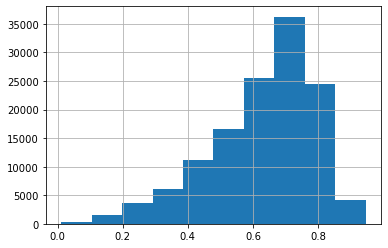

In [24]:
df_fin['vote_share_rep'].hist()

In [35]:
df_fin['declarations'] = np.select([
    (df_fin['post_sah']==0)&(df_fin['post_soe']==0),
    (df_fin['post_sah']==0)&(df_fin['post_soe']==1),
    (df_fin['post_sah']==1)&(df_fin['post_soe']==1)],
    ['no_declaration','state_declaration','home_declaration']
)

In [89]:
#df_fin[['vote_share_q','state_x']].groupby(['vote_share_q','state_x']).size().reset_index().sort_values(by=['vote_share_q',0]).to_csv('text.csv')
df.groupby(['state','FIPS']).size().to_csv('full.csv')
df_fin.groupby(['state_x','FIPS']).size().to_csv('sam.csv')

In [69]:
df_fin['vote_share_q'] = pd.qcut(df_fin['vote_share_rep'],5,labels=[1,2,3,4,5])
grp_cats_1 = pd.melt(df_fin, id_vars=['FIPS', 'date','obs','republican'], value_vars=['retail','food_drugs','transit','work','homes']) 
grp_cats_2 = pd.melt(df_fin, id_vars=['FIPS', 'date','republican','post_sah'], value_vars=['retail','food_drugs','transit','work','homes']) 
grp_cats_3 = pd.melt(df_fin, id_vars=['FIPS', 'date','vote_share_q','post_sah'], value_vars=['retail','food_drugs','transit','work','homes']) 
grp_cats_4 = pd.melt(df_fin, id_vars=['FIPS', 'date','vote_share_q','declarations'], value_vars=['retail','food_drugs','transit','work','homes']) 

1    25969
2    25943
5    25941
4    25935
3    25922
Name: vote_share_q, dtype: int64
0    25969
1    25943
Name: state_x, dtype: int64


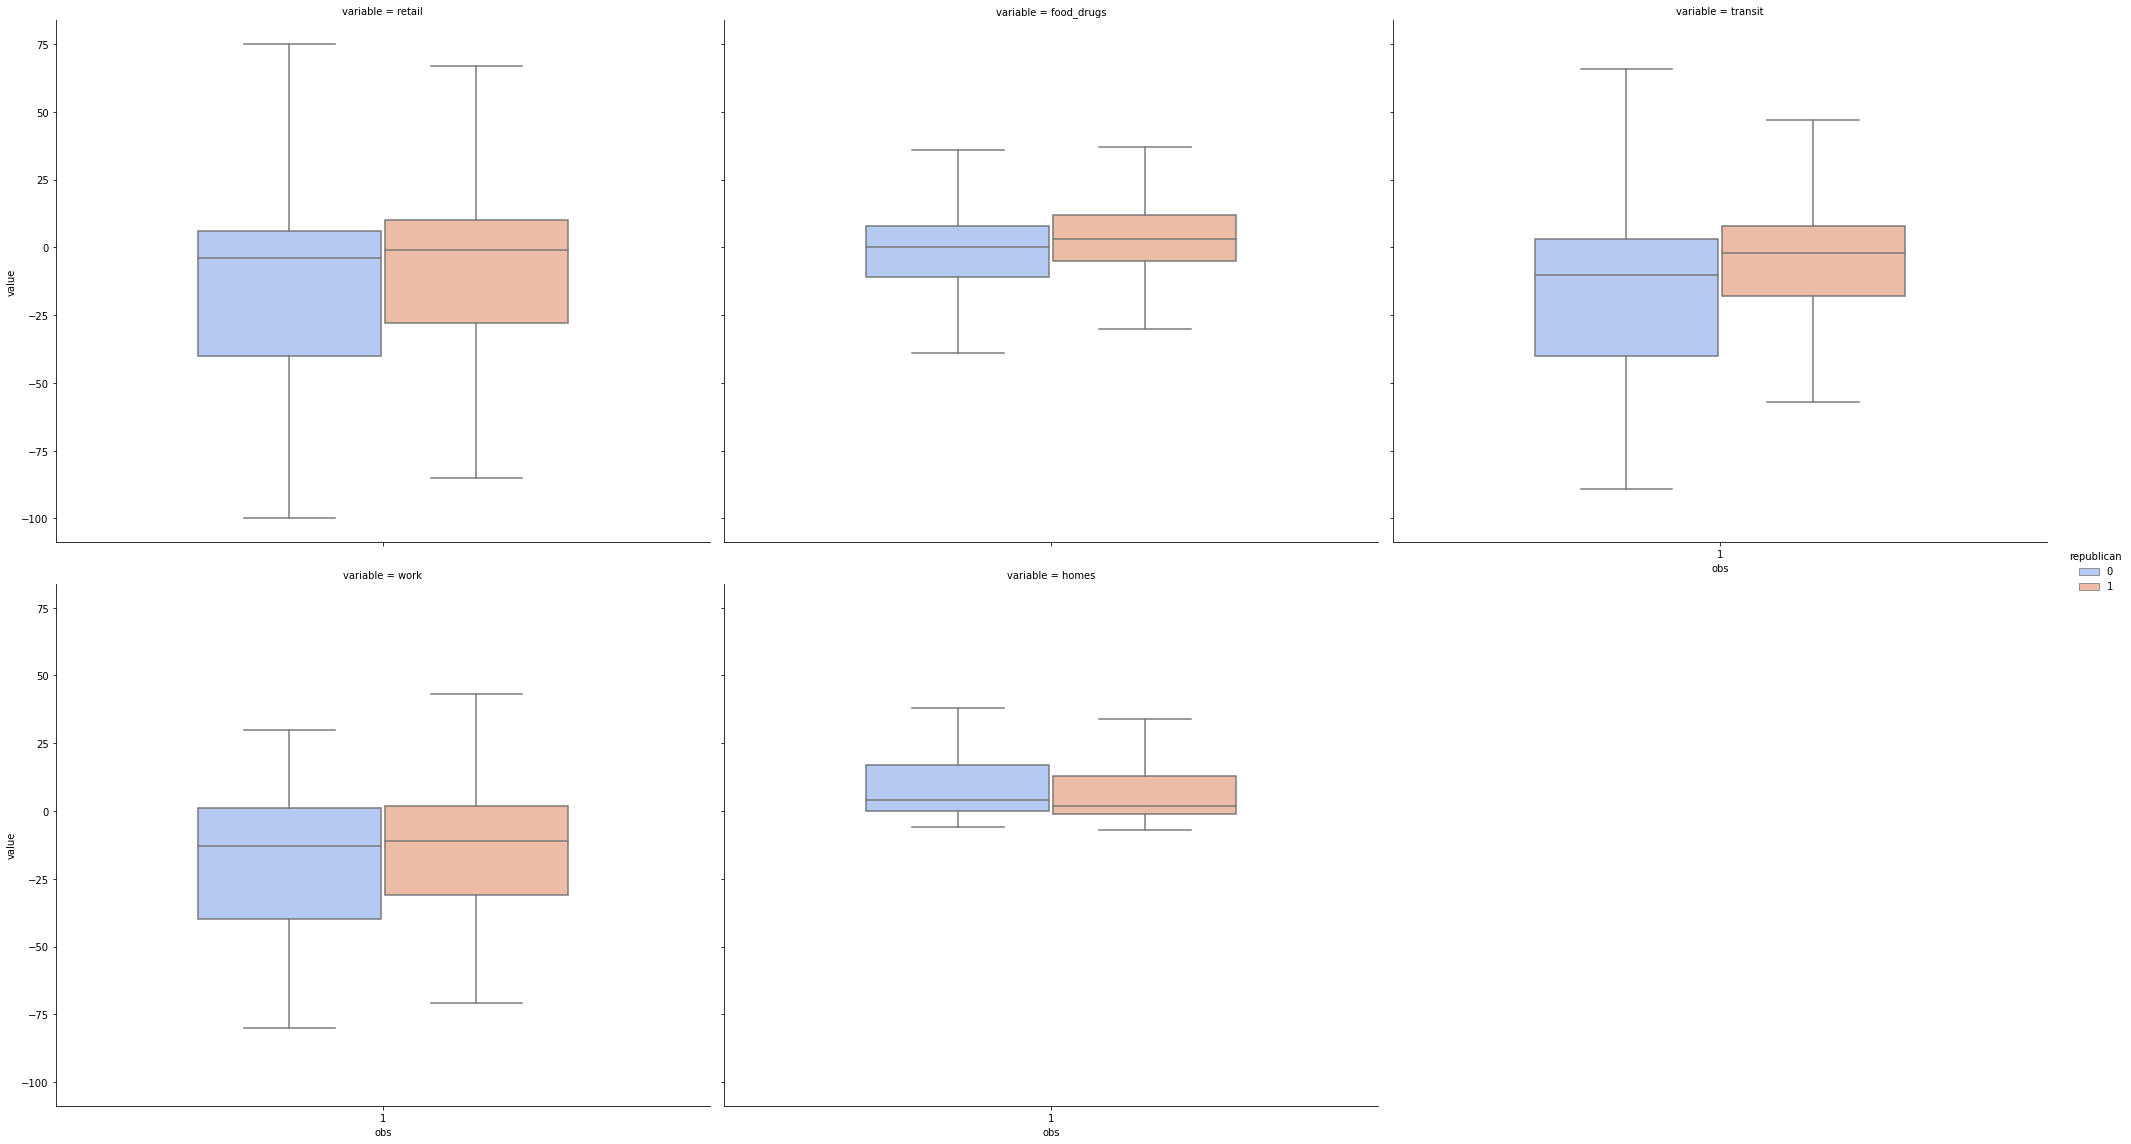

In [42]:
sns.catplot(x='obs',y="value", hue='republican',
            col="variable",
                data=grp_cats_1, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 2 ))

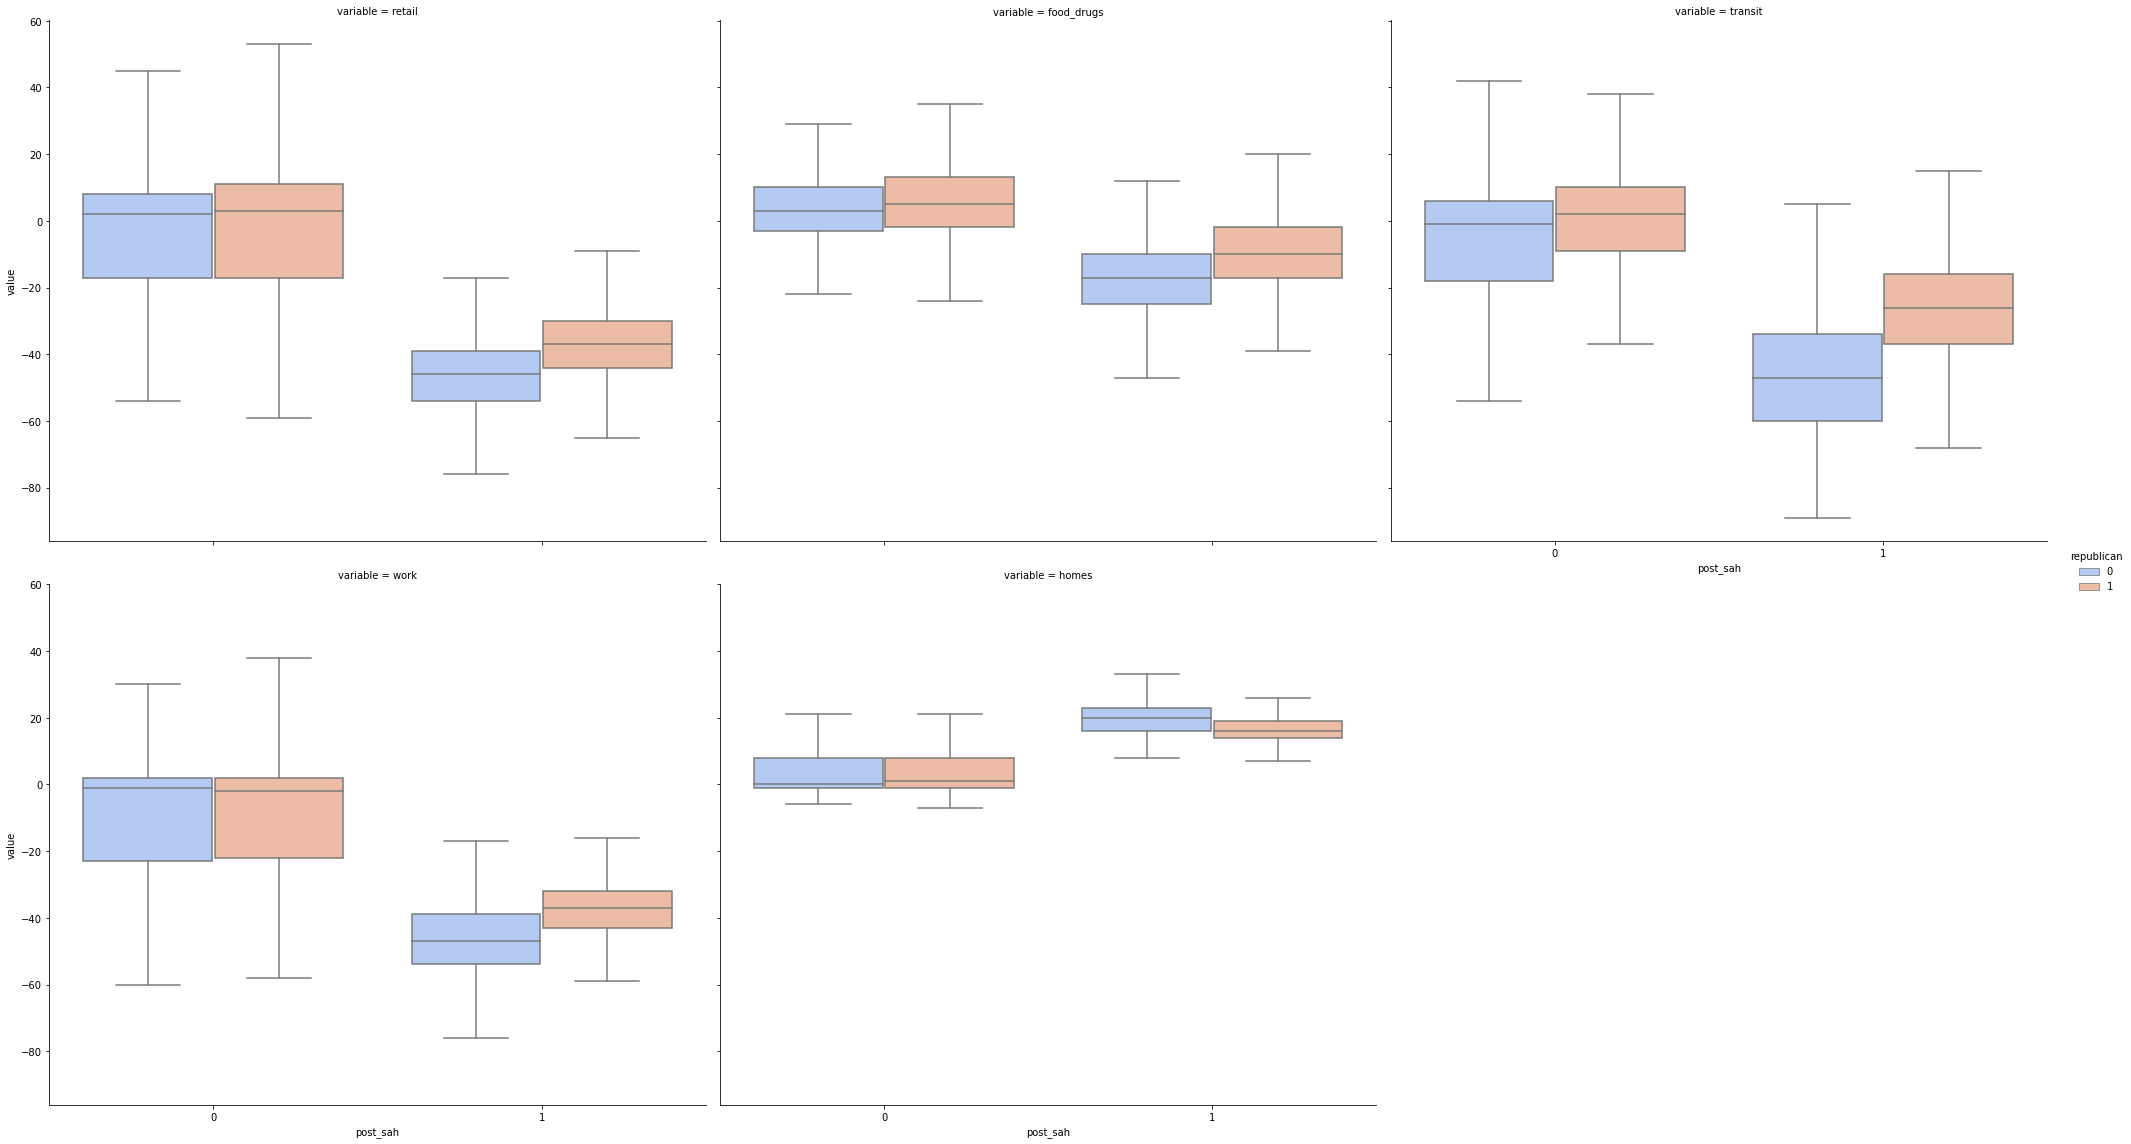

In [43]:
sns.catplot(x="post_sah", y="value", hue='republican',
            col="variable",
                data=grp_cats_2, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 2))

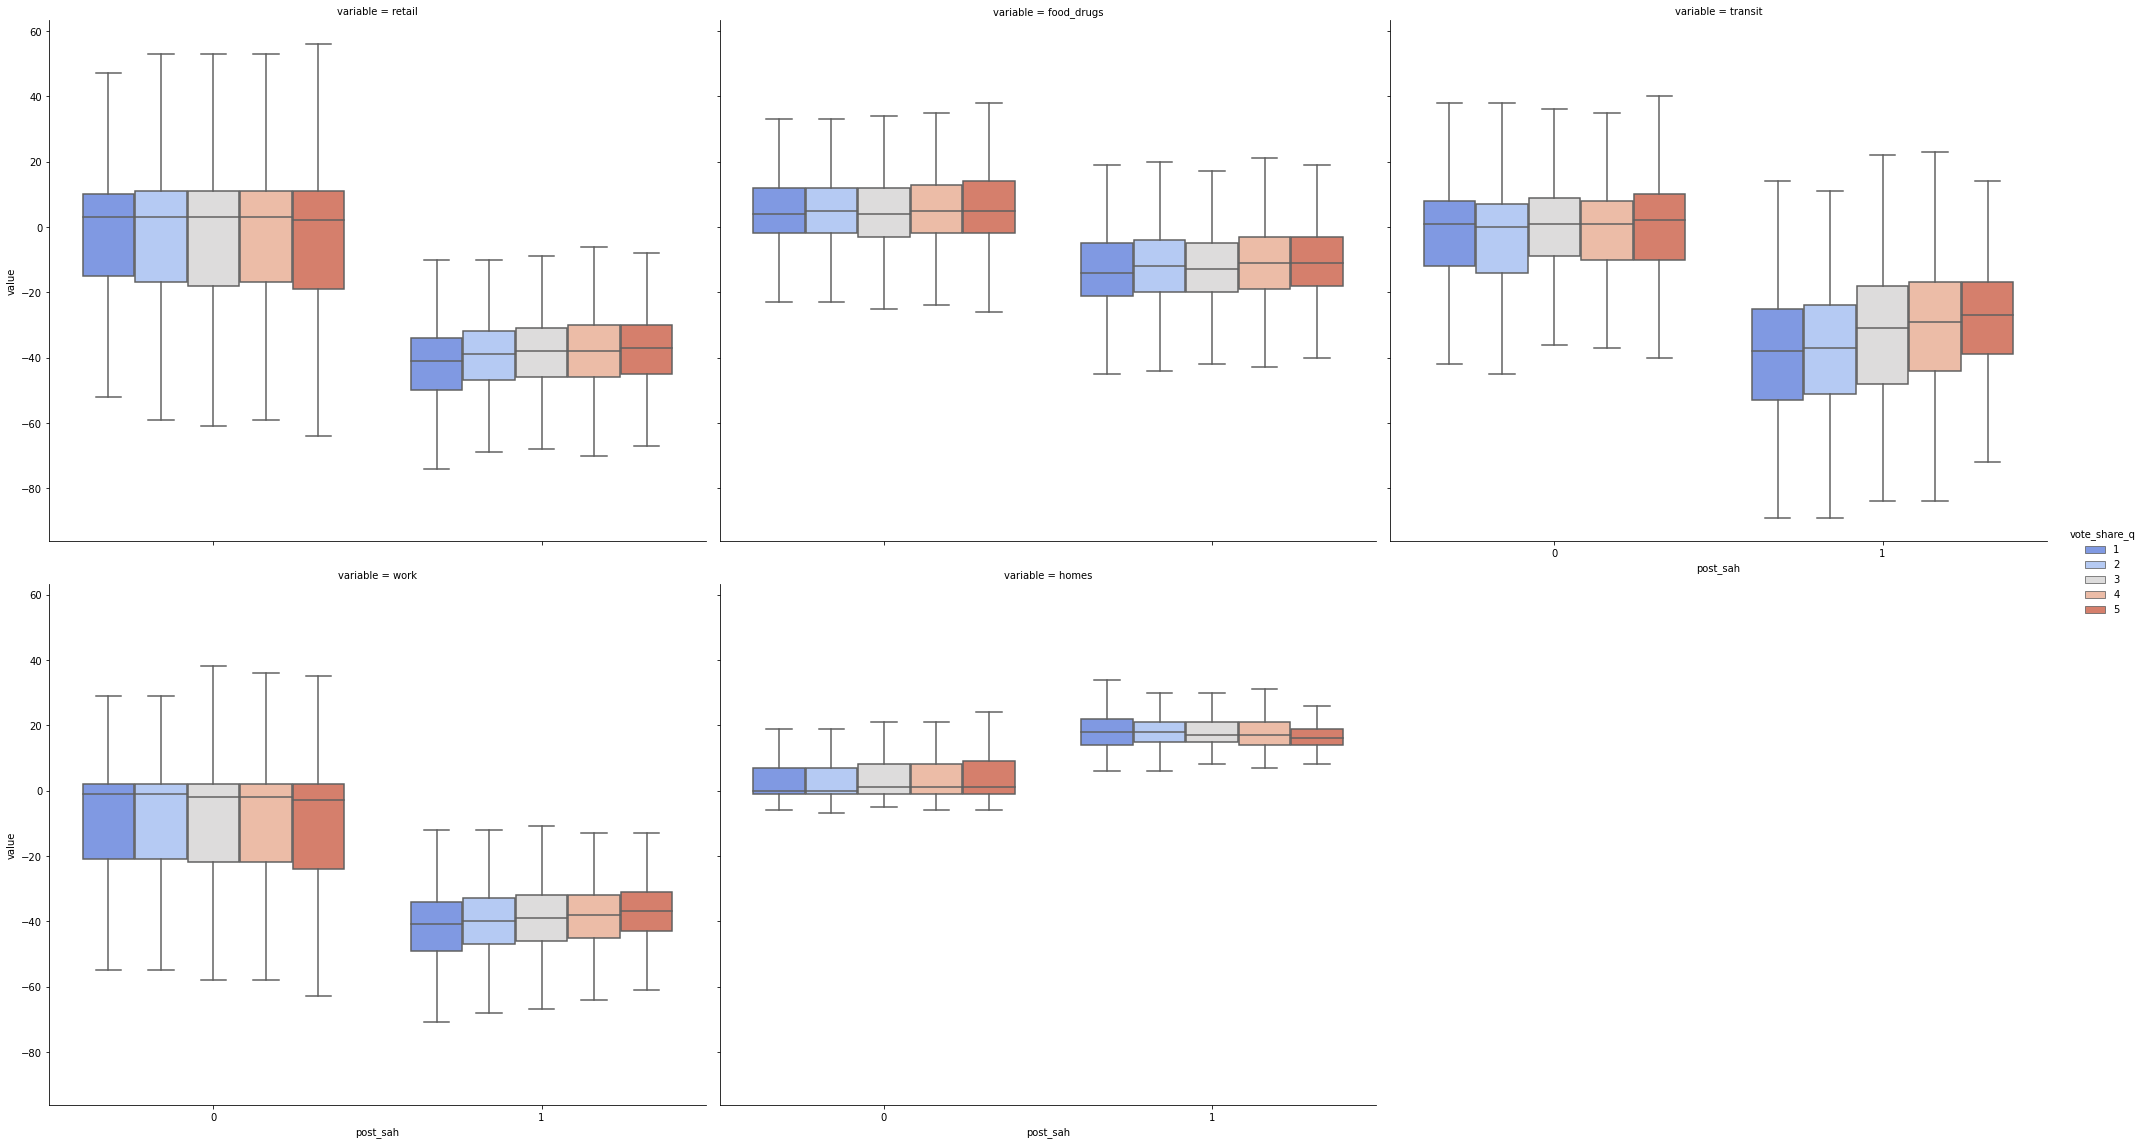

In [44]:
sns.catplot(x="post_sah", y="value", hue='vote_share_q',
            col="variable",
                data=grp_cats_3, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 5))

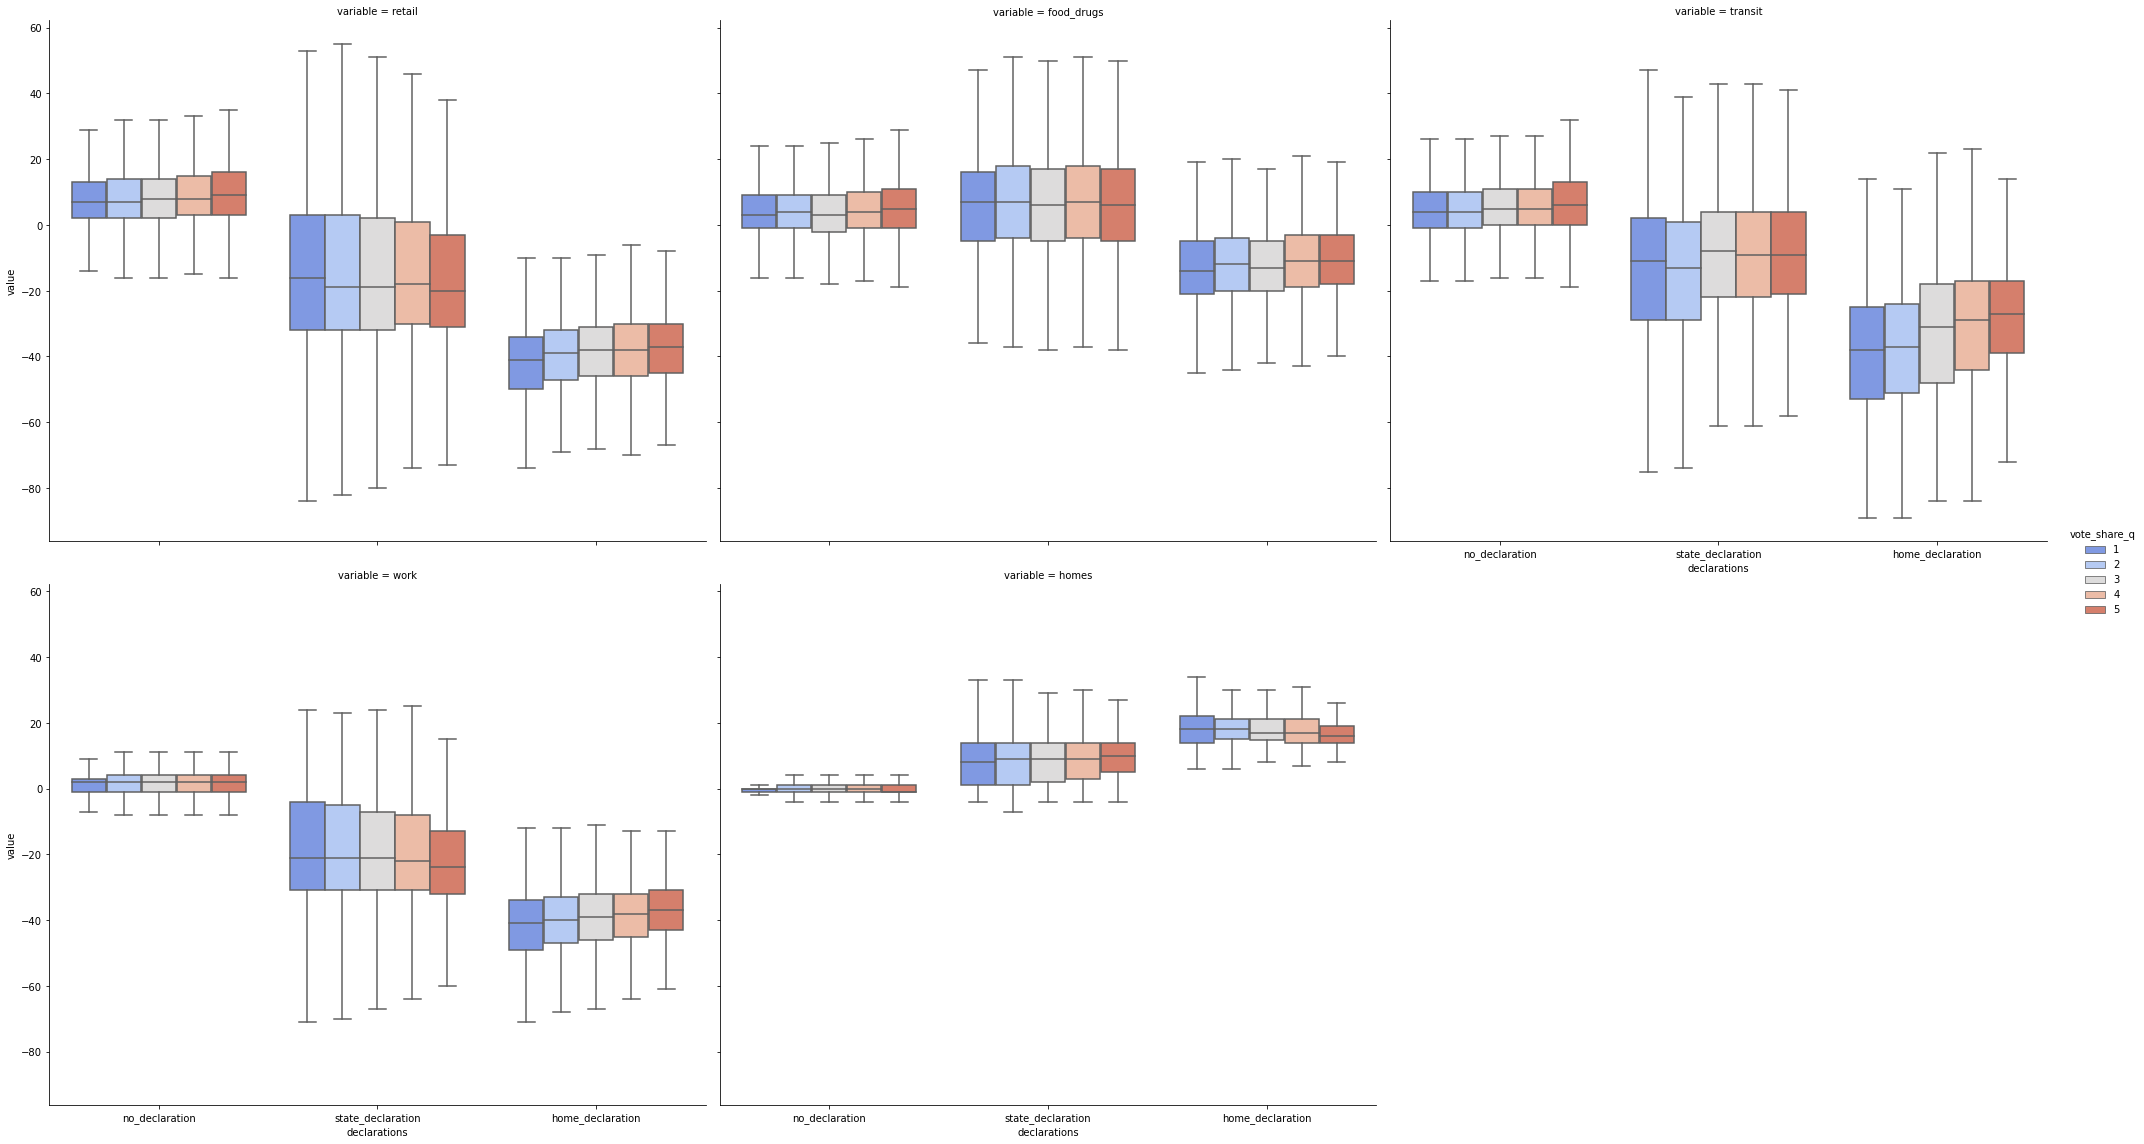

In [45]:
sns.catplot(x="declarations", y="value", hue='vote_share_q',
            col="variable",
                data=grp_cats_4, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 5))

In [36]:
df_fin['vote_share_q'] = pd.qcut(df_fin['vote_share_rep'],5,labels=[1,2,3,4,5])
print(df_fin['vote_share_q'].describe())
grp_cats_1 = pd.melt(df_fin[df_fin['no_miss_days']==1], id_vars=['FIPS', 'date','obs','republican'], value_vars=['retail','food_drugs','transit','work','homes']) 
grp_cats_2 = pd.melt(df_fin[df_fin['no_miss_days']==1], id_vars=['FIPS', 'date','republican','post_sah'], value_vars=['retail','food_drugs','transit','work','homes']) 
grp_cats_3 = pd.melt(df_fin[df_fin['no_miss_days']==1], id_vars=['FIPS', 'date','vote_share_q','post_sah'], value_vars=['retail','food_drugs','transit','work','homes']) 
grp_cats_4 = pd.melt(df_fin[df_fin['no_miss_days']==1], id_vars=['FIPS', 'date','vote_share_q','declarations'], value_vars=['retail','food_drugs','transit','work','homes']) 

count     129710
unique         5
top            1
freq       25969
Name: vote_share_q, dtype: int64


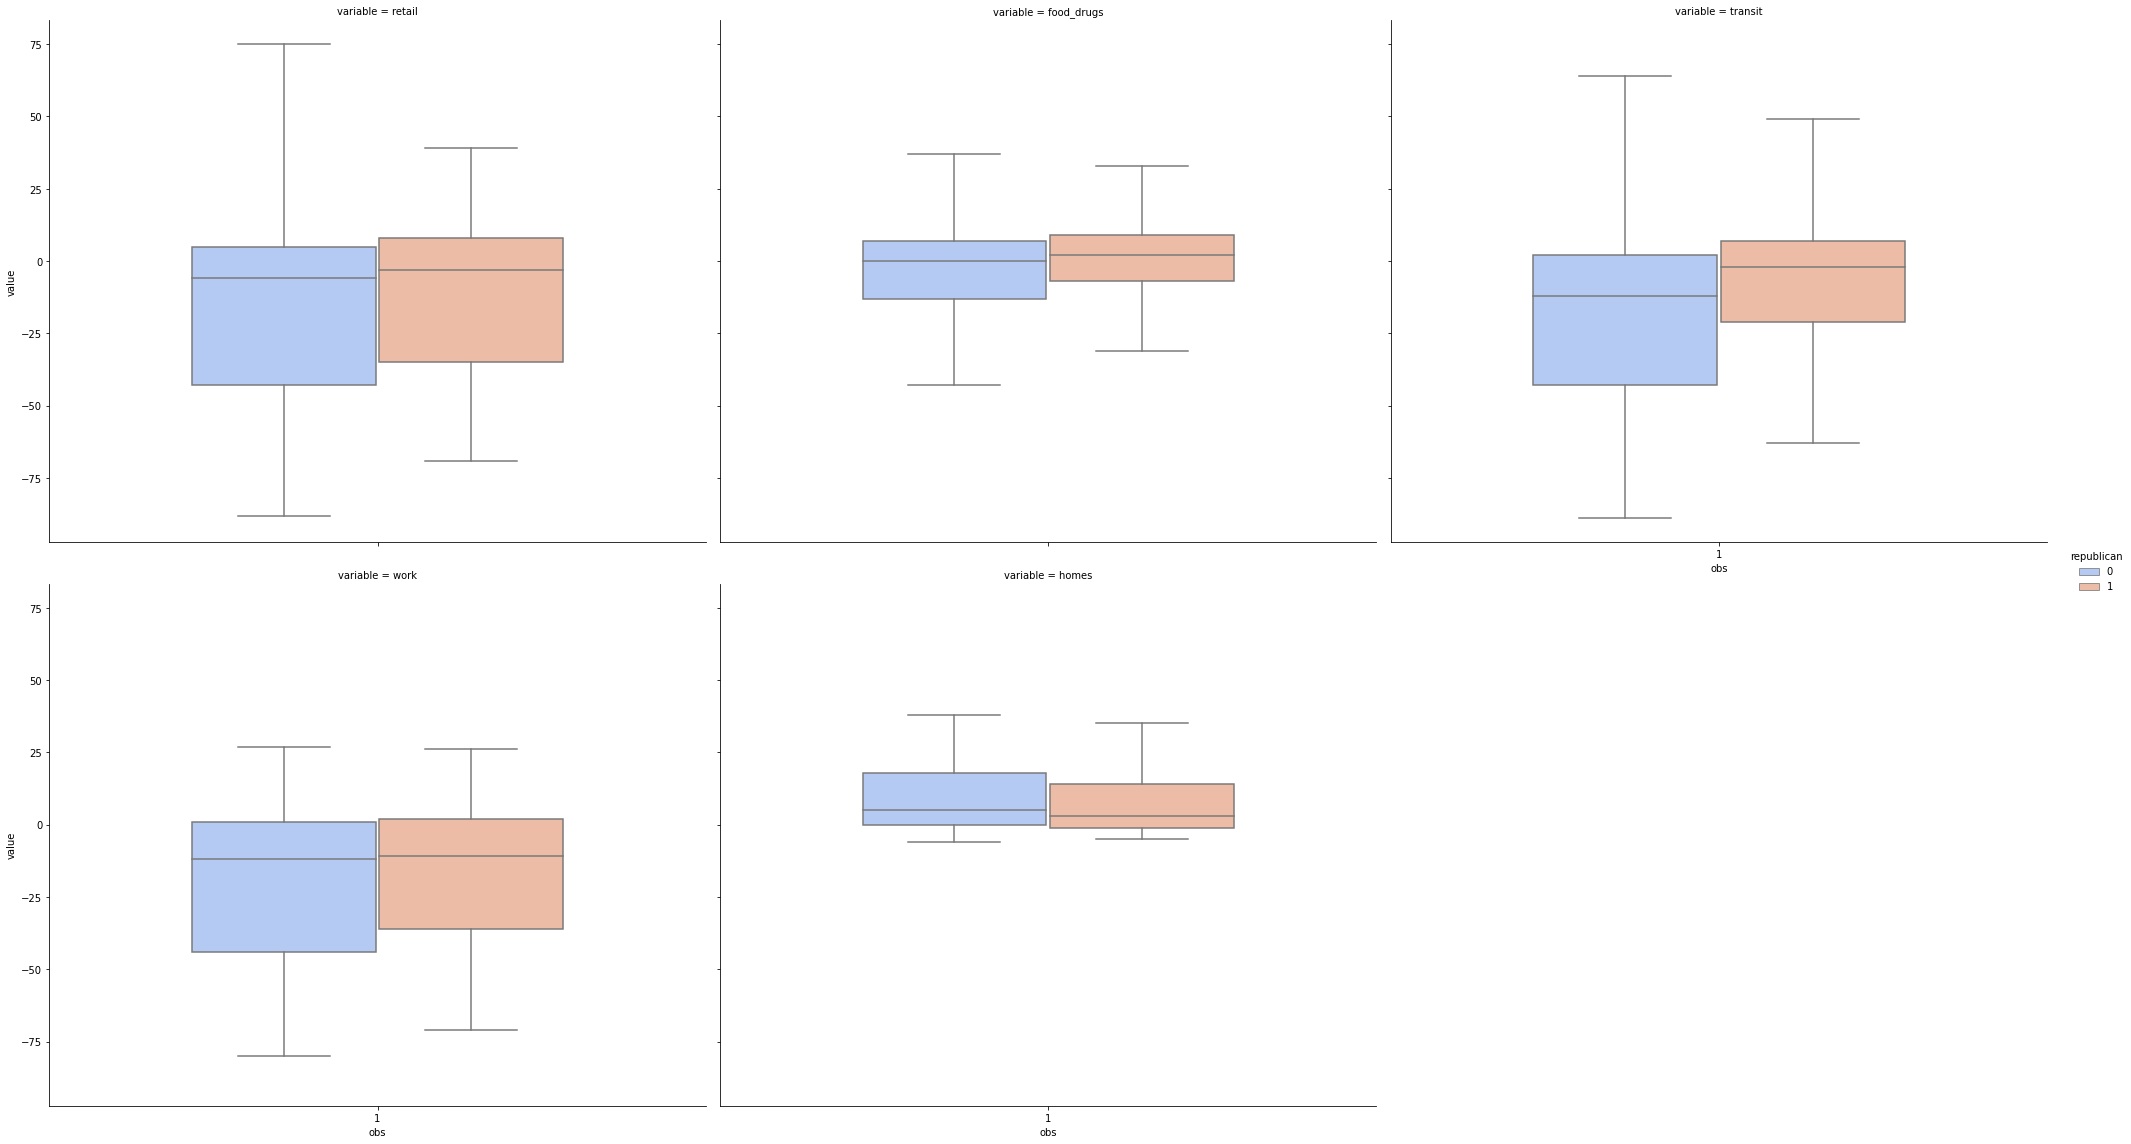

In [33]:
sns.catplot(x='obs',y="value", hue='republican',
            col="variable",
                data=grp_cats_1, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 2 ))

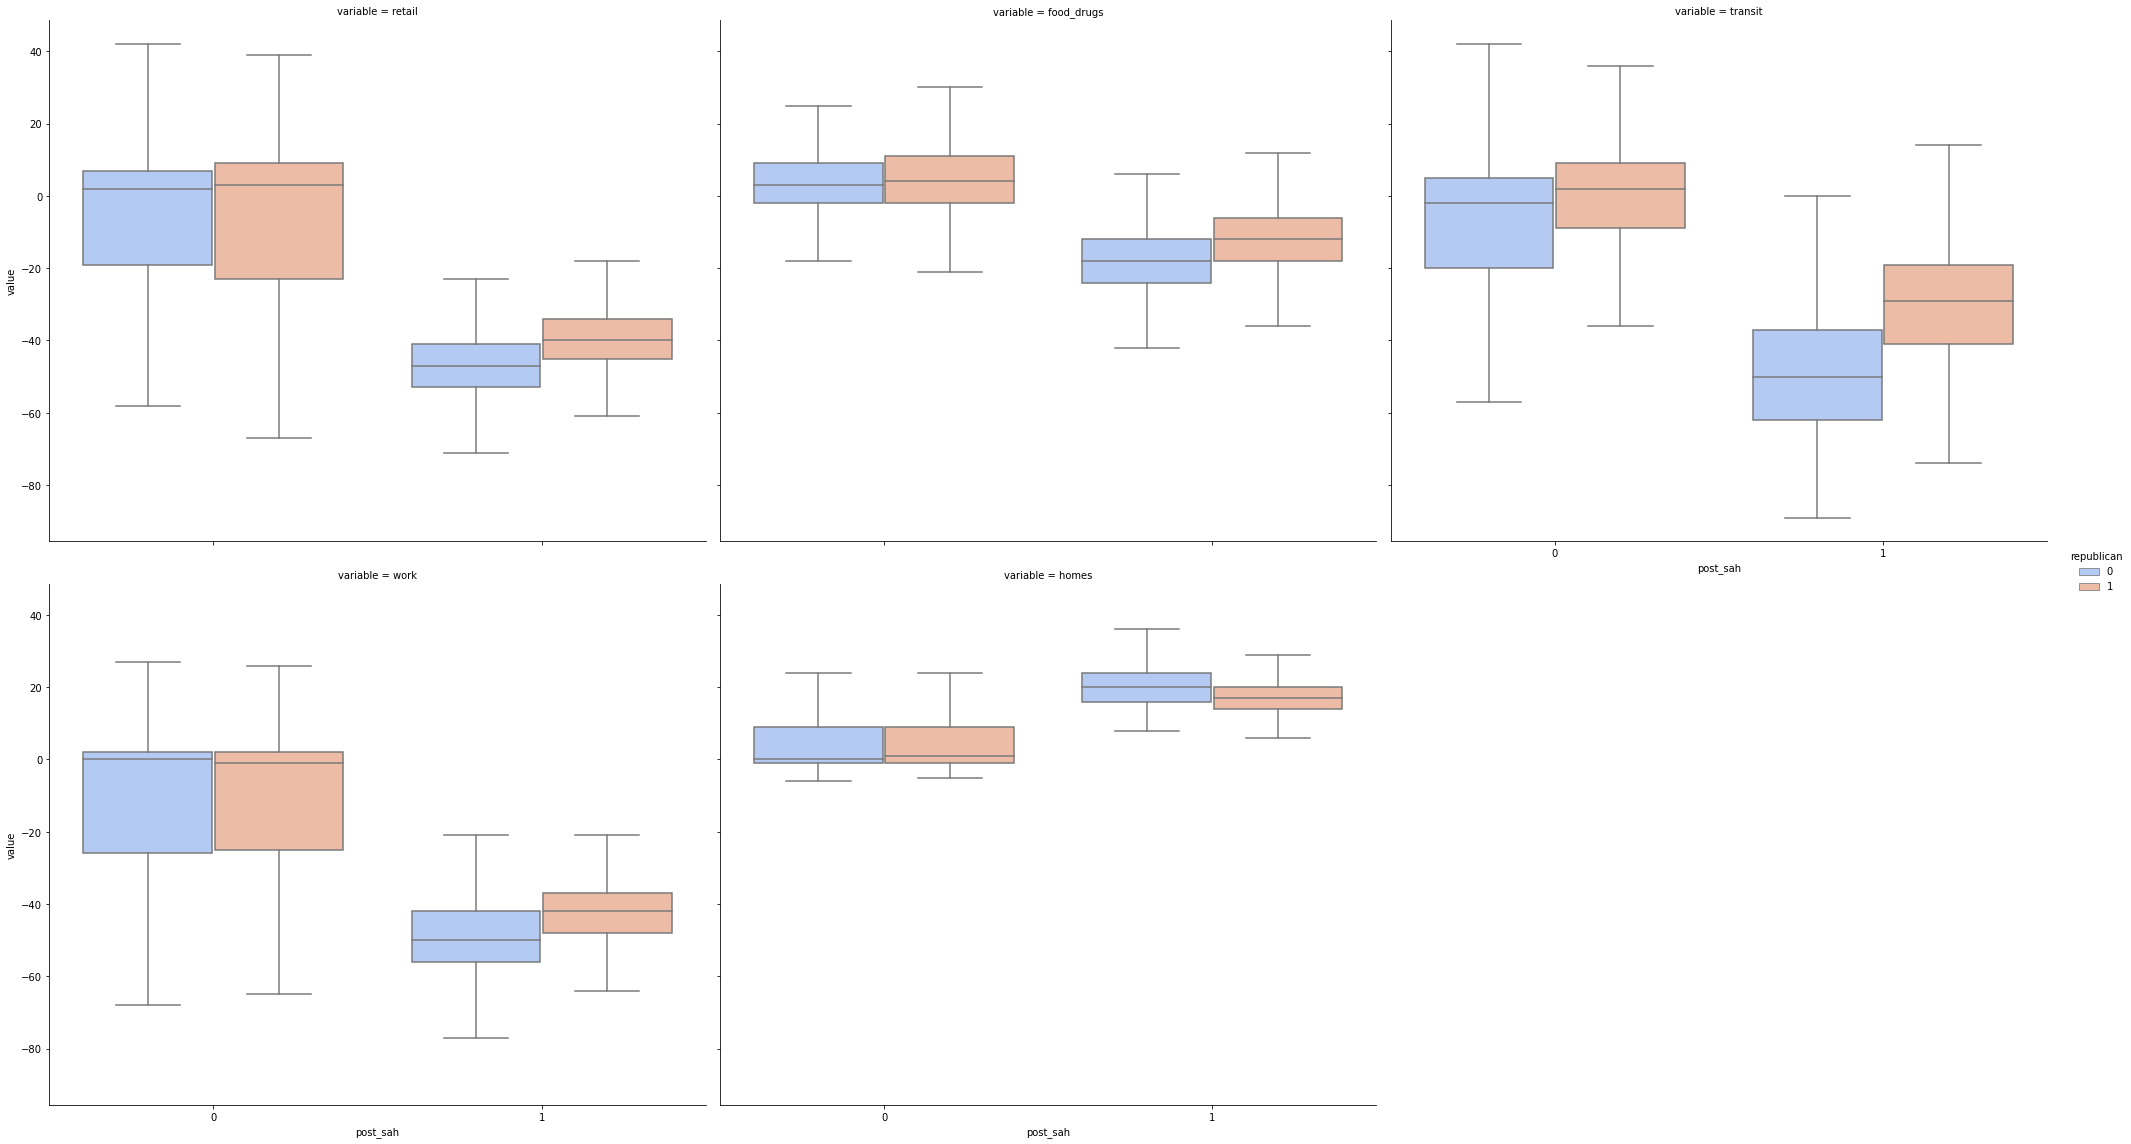

In [40]:
sns.catplot(x="post_sah", y="value", hue='republican',
            col="variable",
                data=grp_cats_2, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 2))

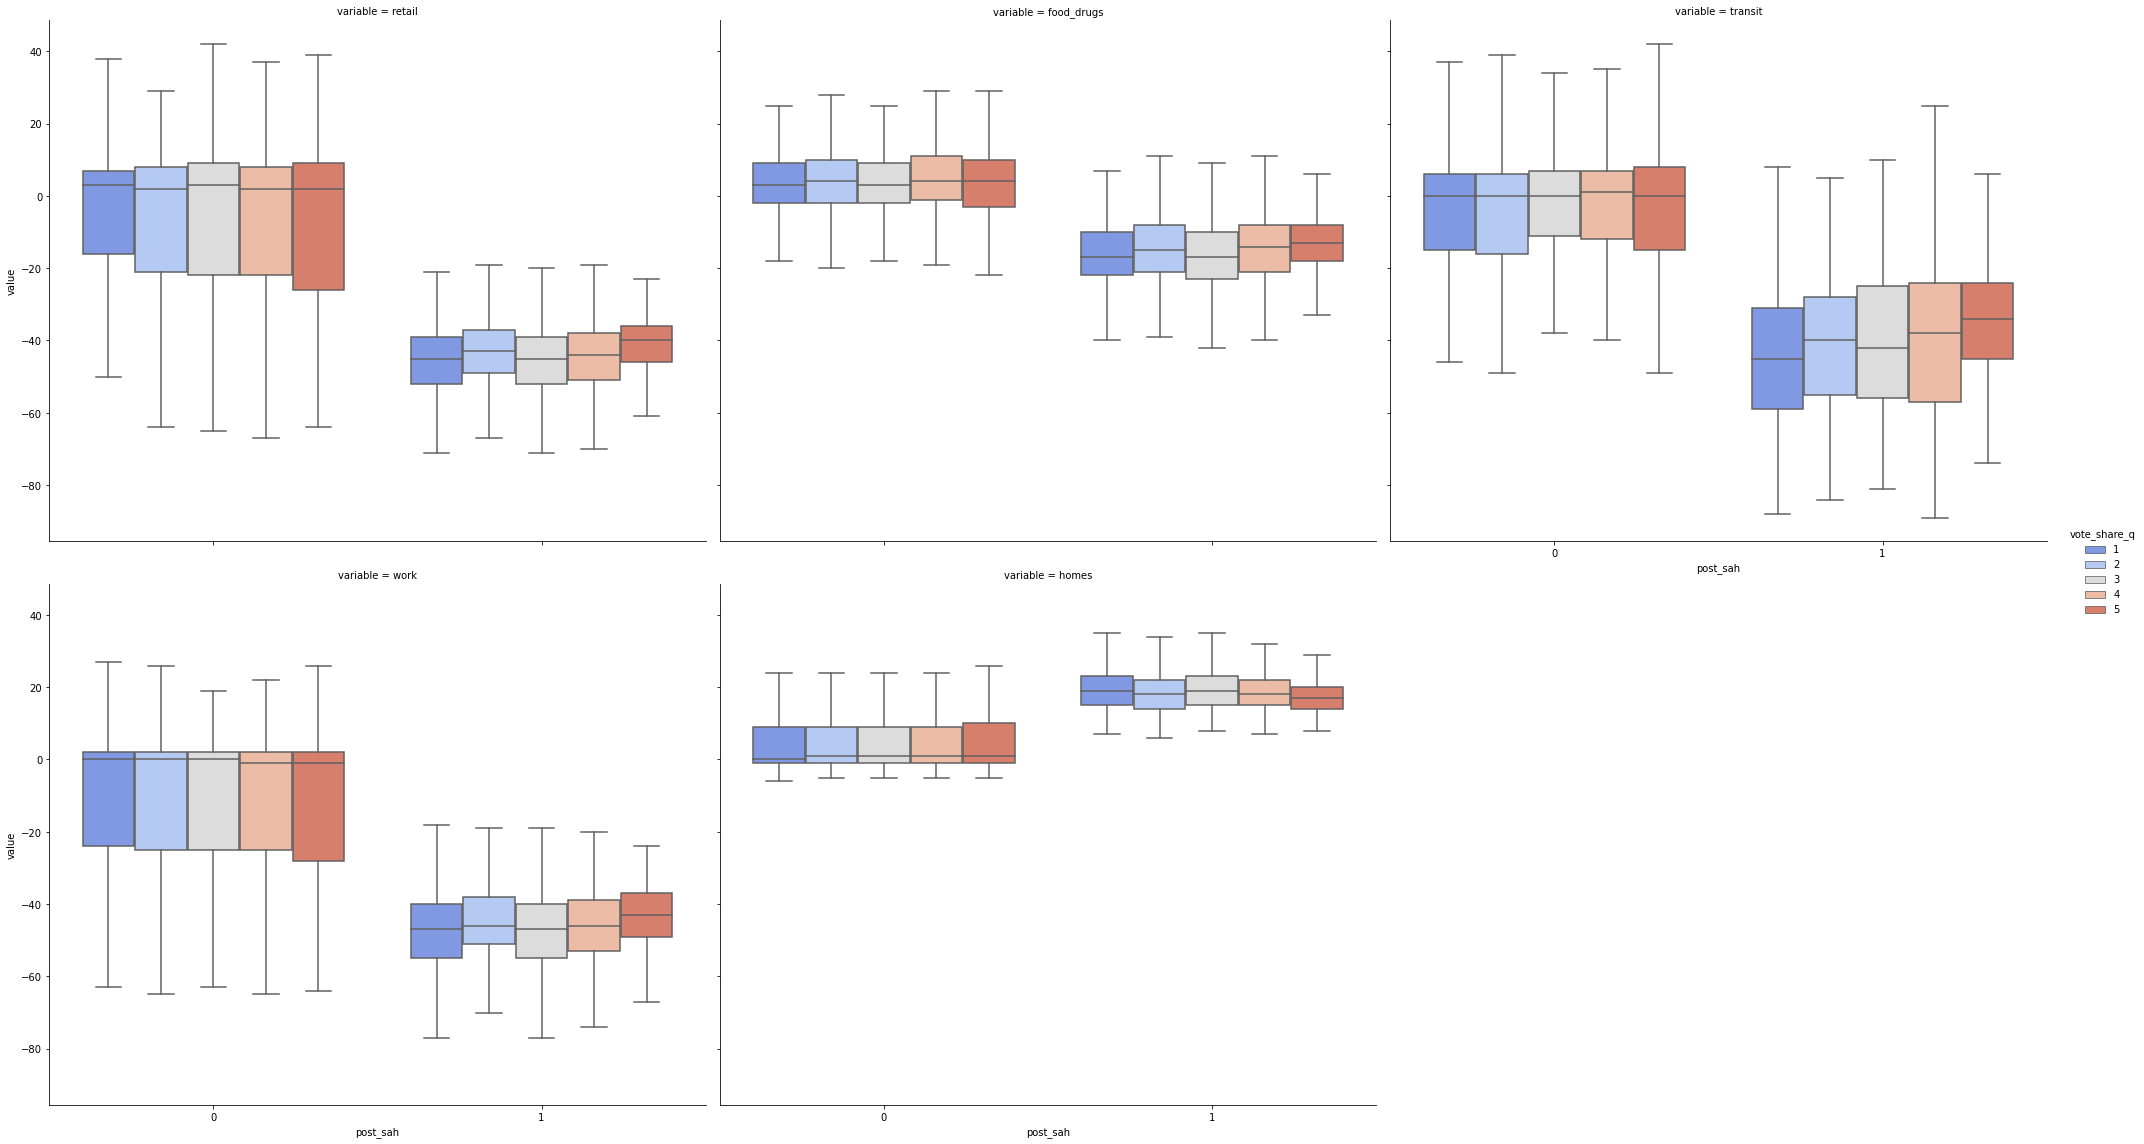

In [68]:
sns.catplot(x="post_sah", y="value", hue='vote_share_q',
            col="variable",
                data=grp_cats_3, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 5))

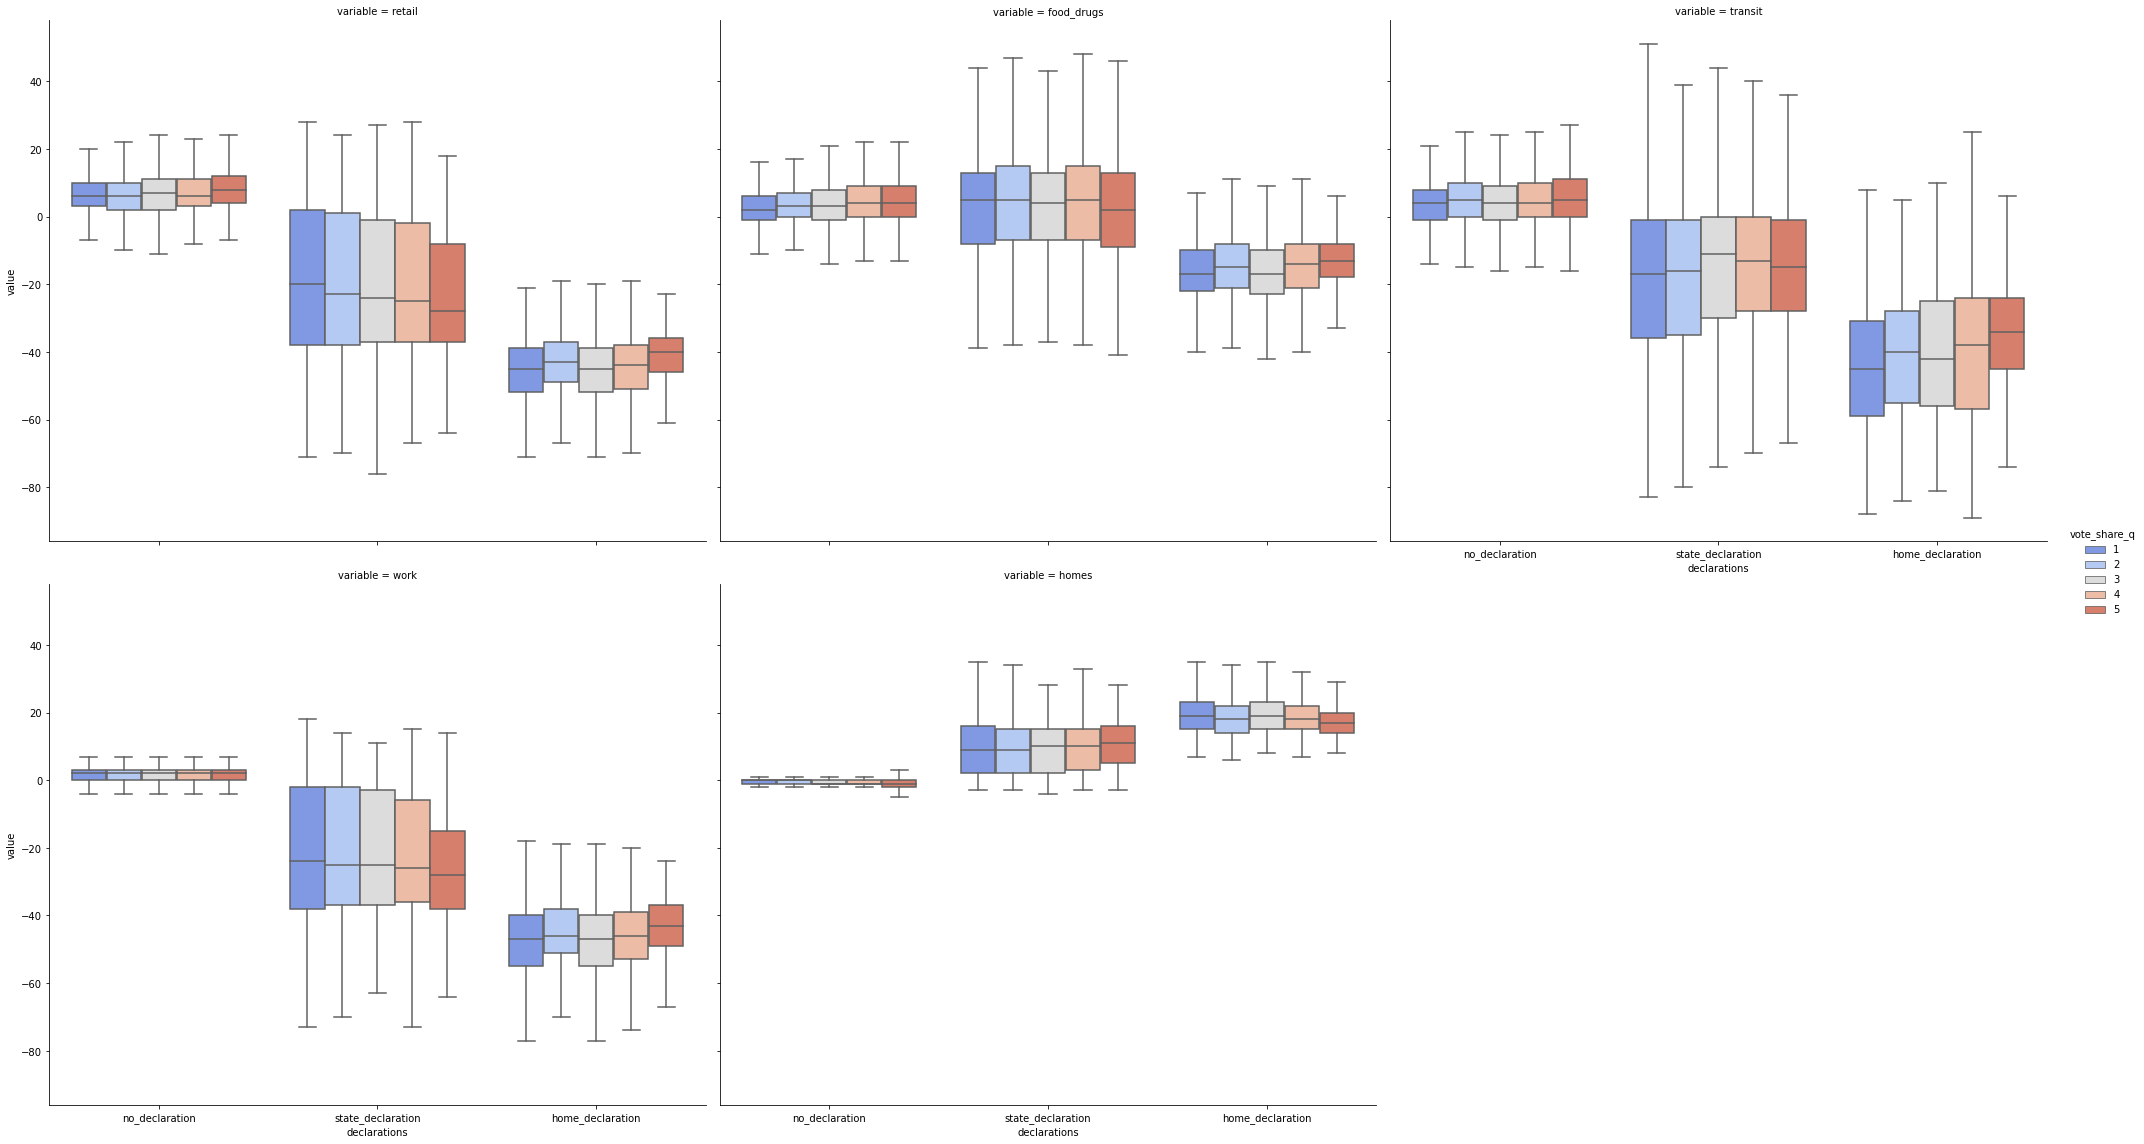

In [38]:
sns.catplot(x="declarations", y="value", hue='vote_share_q',
            col="variable",
                data=grp_cats_4, kind="box",
                height=8, aspect=1.2,col_wrap=3,showfliers=False,  palette=sns.color_palette("coolwarm", 5))

In [20]:
grp_1 = pd.melt(df_tog, id_vars=['FIPS', 'date'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_1.dropna(inplace=True)
grp_1[['FIPS', 'date']].drop_duplicates().shape

(152039, 2)

In [21]:
grp_2 = pd.melt(df_tog, id_vars=['FIPS', 'date','candidate'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_2.dropna(inplace=True)
grp_2[['FIPS', 'date']].drop_duplicates().shape

(151492, 2)

In [22]:
grp_3 = pd.melt(df_tog, id_vars=['FIPS', 'date','results'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_3.dropna(inplace=True)
grp_3[['FIPS', 'date']].drop_duplicates().shape

(151492, 2)

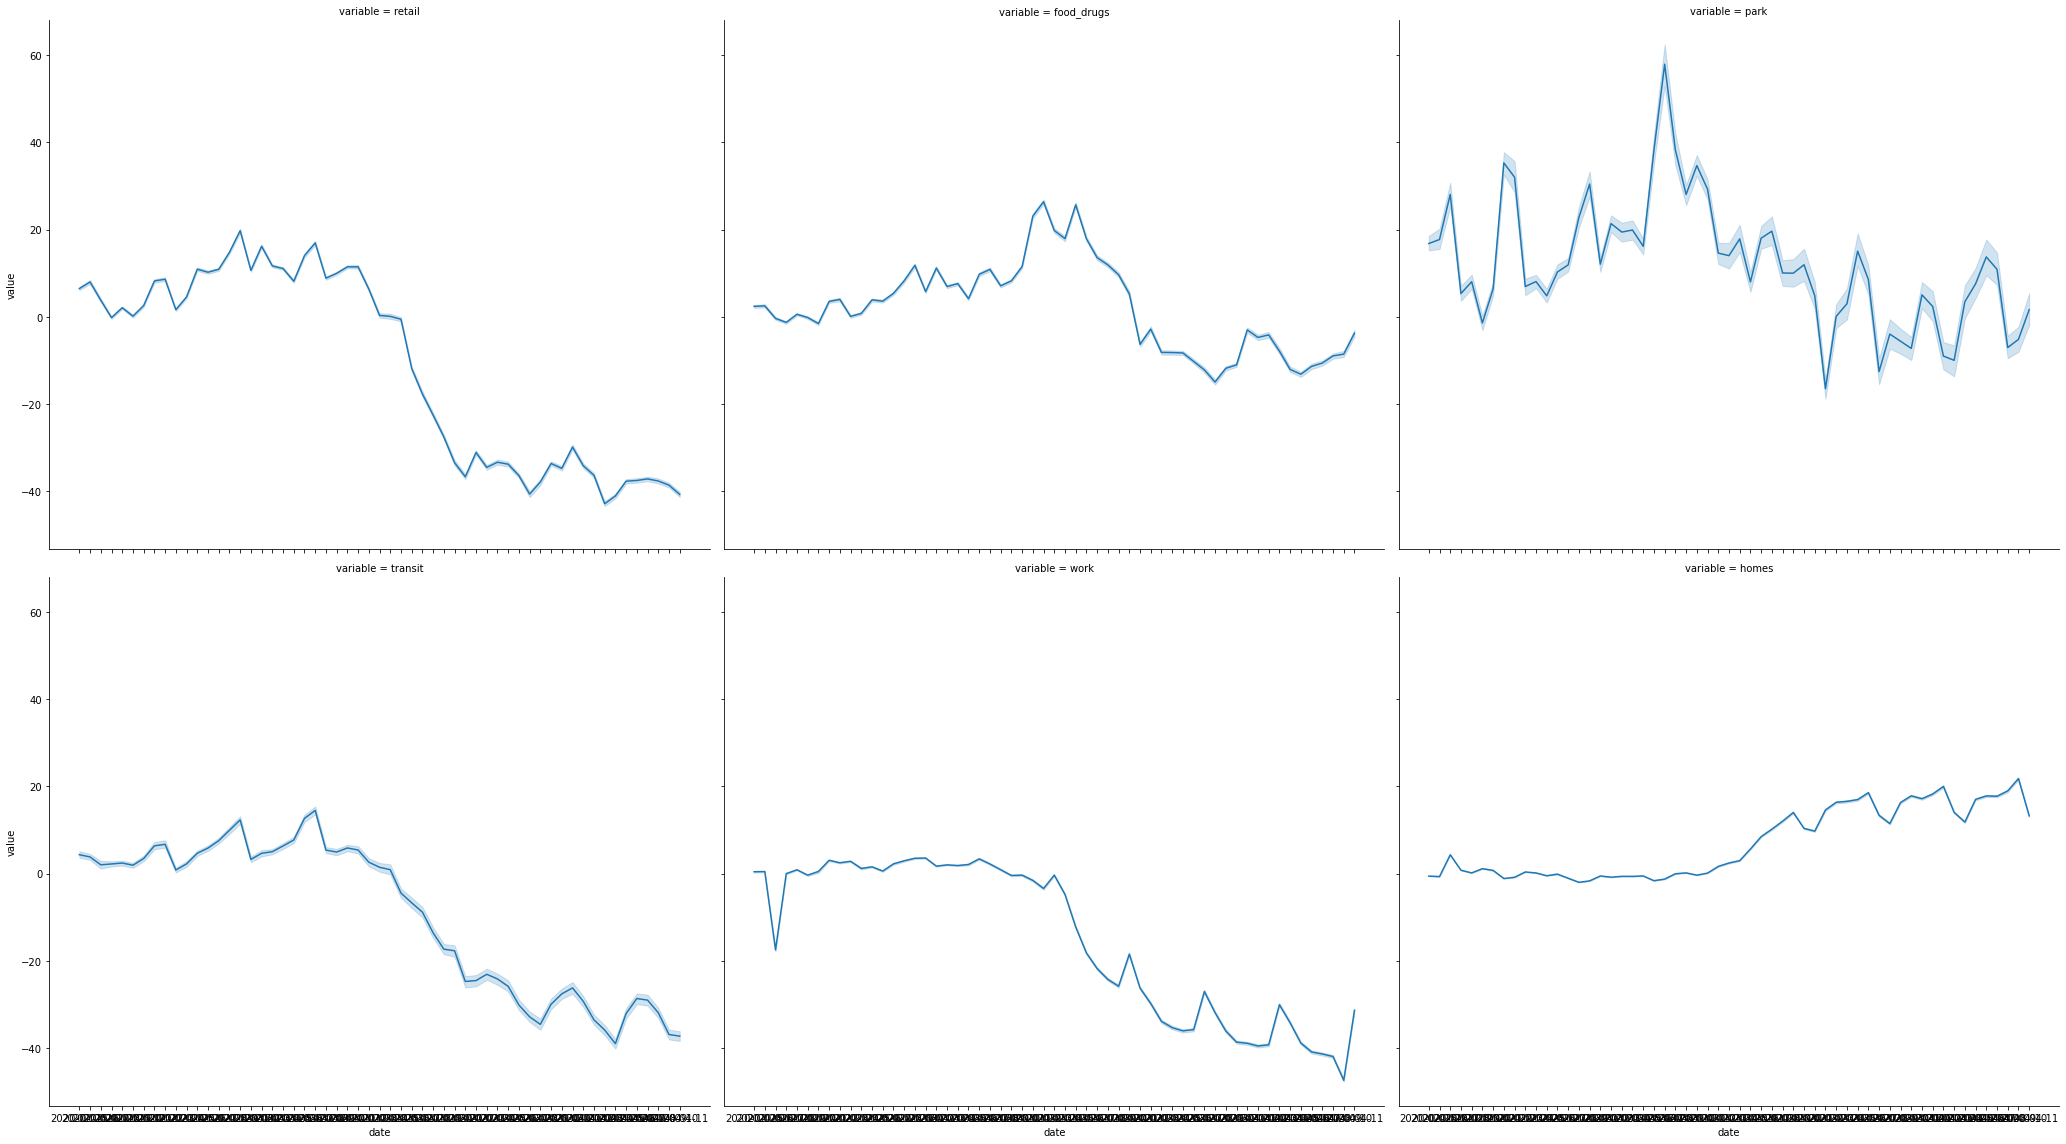

In [23]:
g = sns.relplot(x="date", y="value",
                 col="variable",
                 kind="line", data=grp_1,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_overall.png')

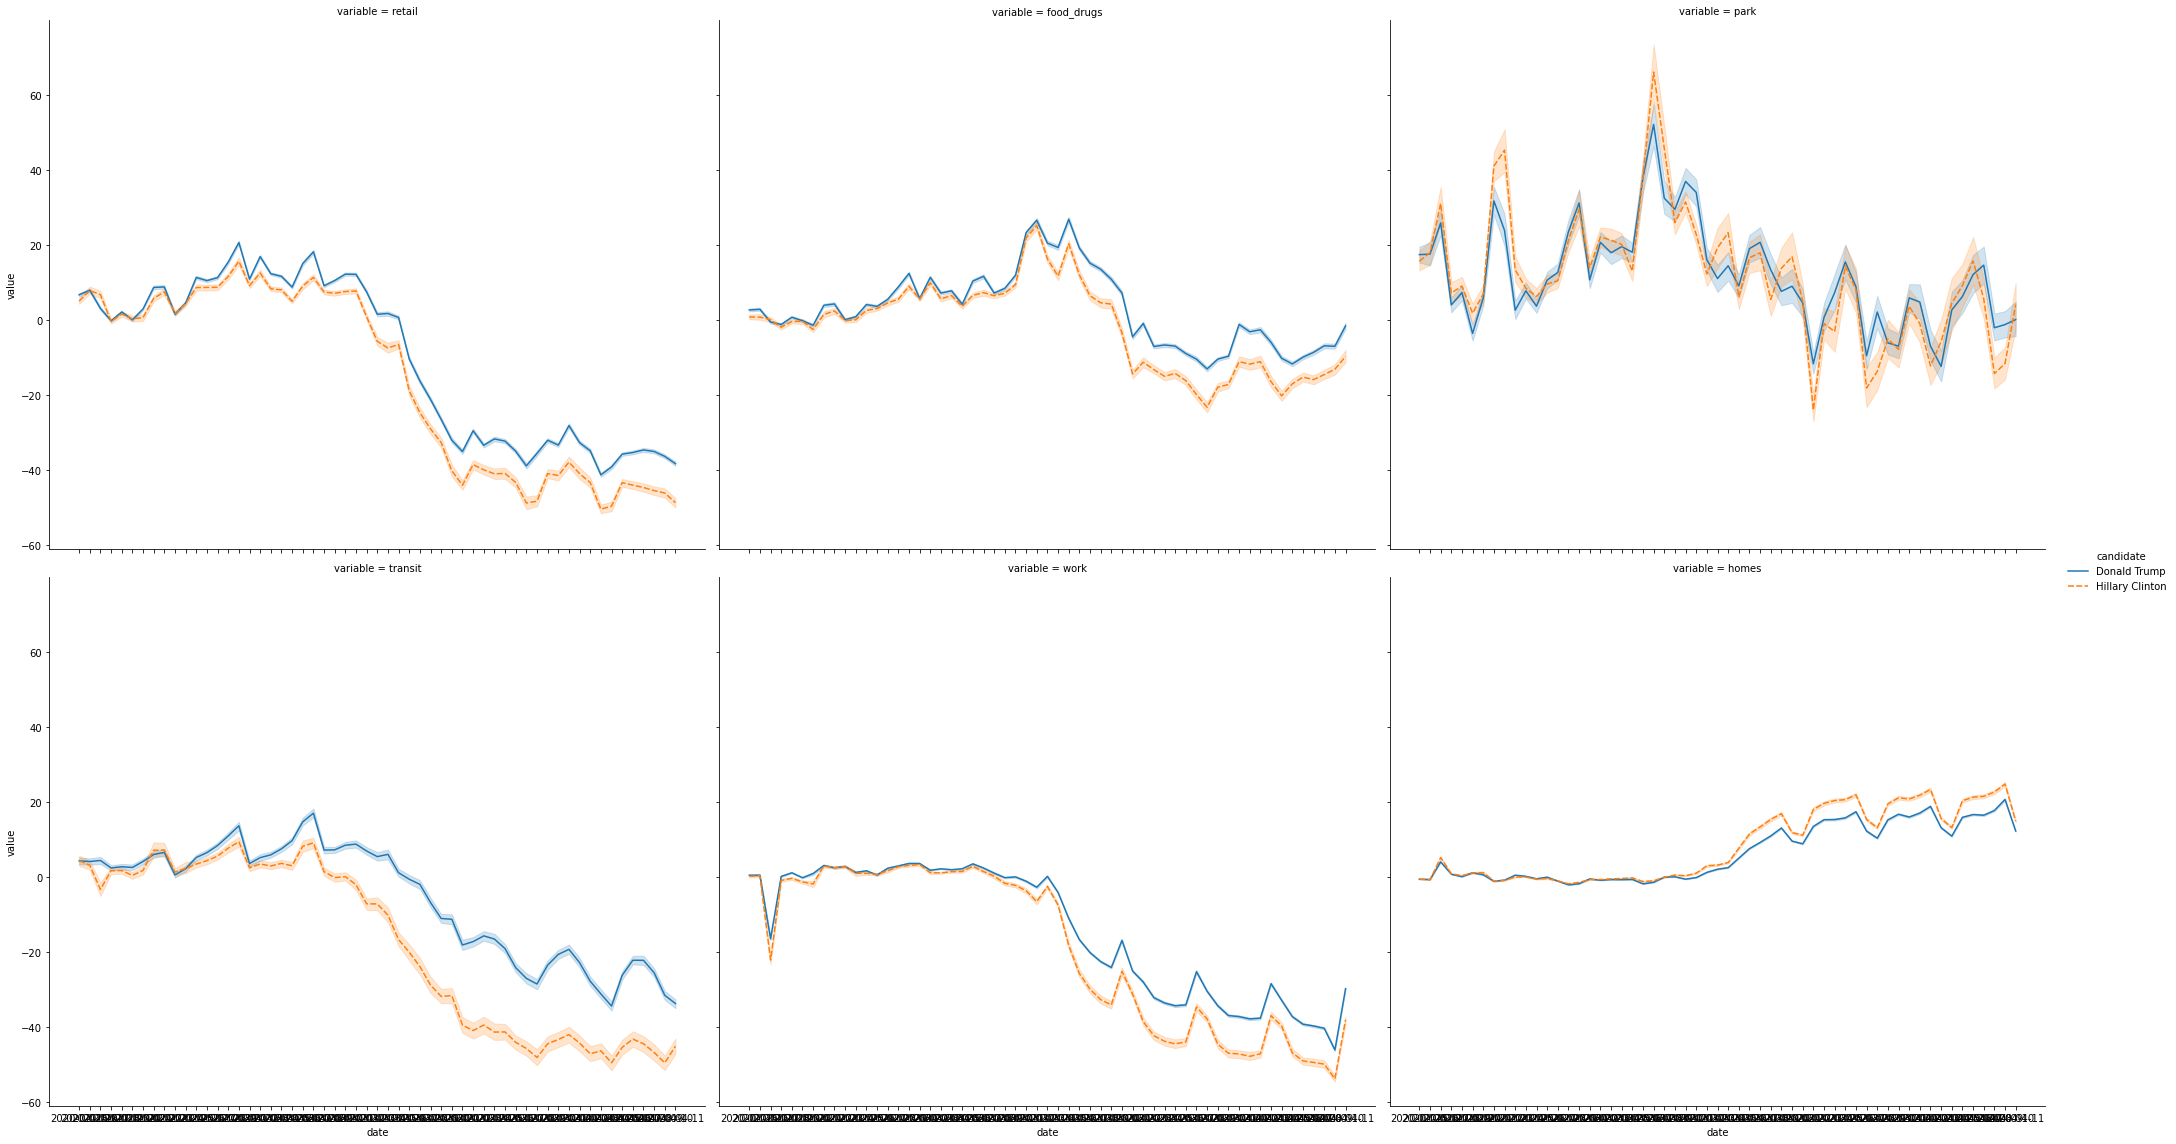

In [24]:
g = sns.relplot(x="date", y="value",
                 col="variable", hue="candidate", style="candidate",
                 kind="line", data=grp_2,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_2016.png')

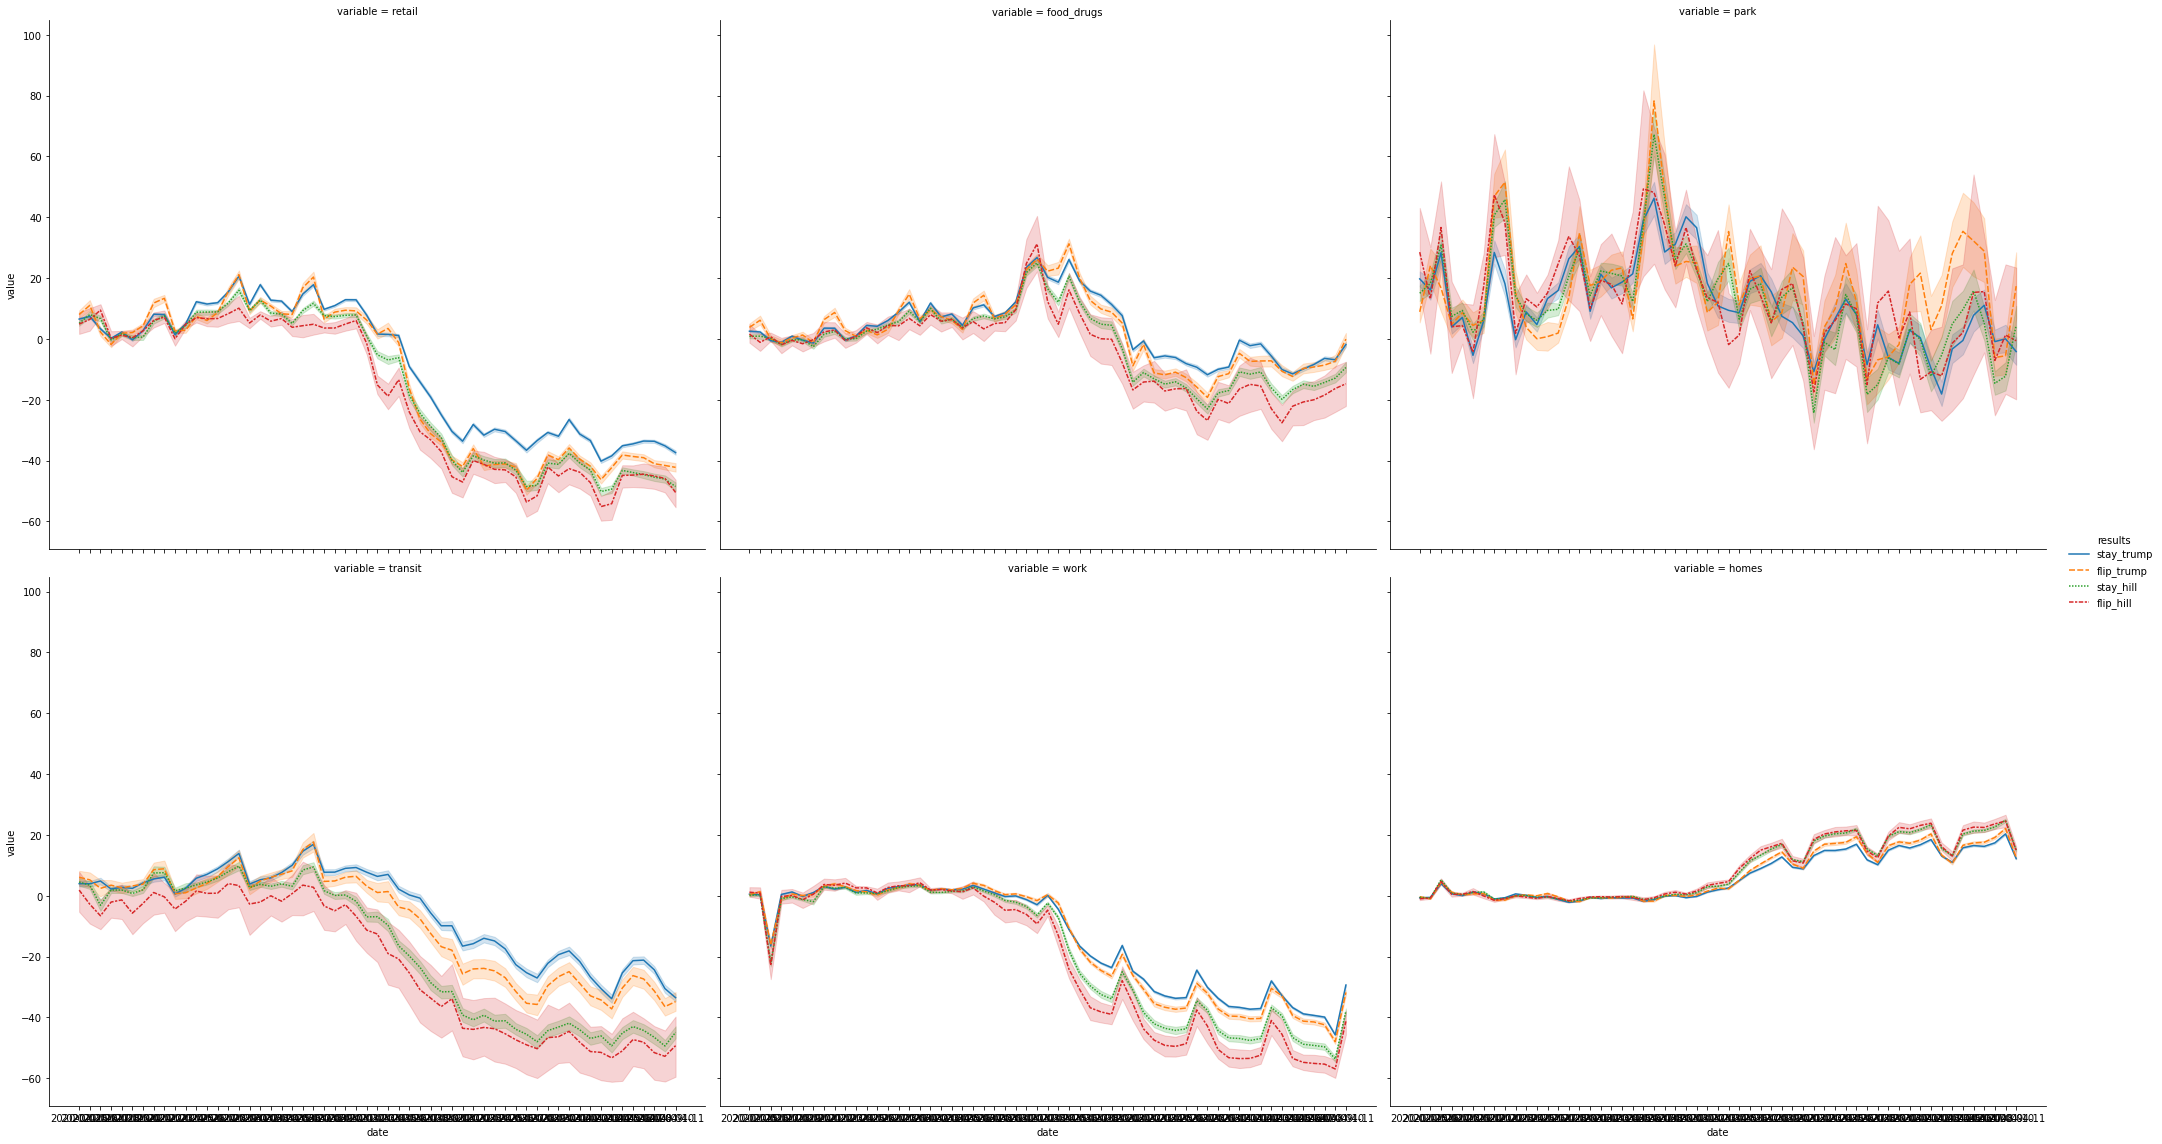

In [25]:
g = sns.relplot(x="date", y="value",
                 col="variable", hue="results", style="results",
                 kind="line", data=grp_3,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_history.png')

# Other variables

In [44]:
df_tog.rename(columns={'Percent of adults with less than a high school diploma, 2014-18':'pct_less_hs',
       'Percent of adults with a high school diploma only, 2014-18':'pct_only_hs',
       "Percent of adults completing some college or associate's degree, 2014-18":'pct_some_co',
       "Percent of adults with a bachelor's degree or higher, 2014-18":'pct_has_co'}, inplace=True)
df_tog.columns.values


array(['country_region_code', 'country_region', 'state_x', 'county_x',
       'date', 'retail', 'food_drugs', 'park', 'transit', 'work', 'homes',
       'source', 'state_abb_x', 'FIPS', 'geo',
       'Less than a high school diploma, 2014-18',
       'High school diploma only, 2014-18',
       "Some college or associate's degree, 2014-18",
       "Bachelor's degree or higher, 2014-18", 'pct_less_hs',
       'pct_only_hs', 'pct_some_co', 'pct_has_co', 'POP_ESTIMATE_2018',
       'N_POP_CHG_2018', 'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018',
       'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018',
       'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'POVALL_2018',
       'CI90LBAll_2018', 'CI90UBALL_2018', 'PCTPOVALL_2018',
       'CI90LBALLP_2018', 'CI90UBALLP_2018', 'POV017_2018',
       'CI90LB017_2018', 'CI90UB017_2018', 'PCTPOV017_2018',


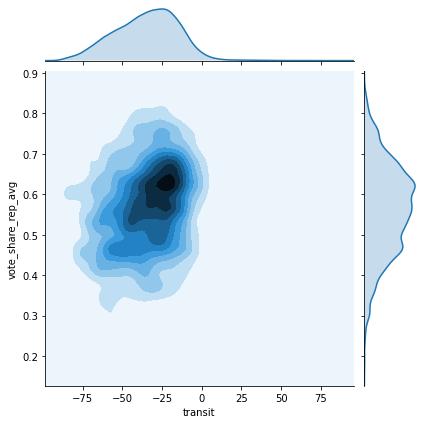

In [27]:
sns.jointplot(x=df_fin[df_fin['post_sah']==1]['transit'], y=df_fin[df_fin['post_sah']==1]['vote_share_rep_avg'], kind="kde")

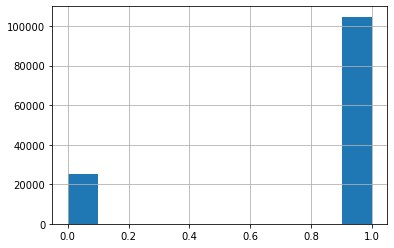

In [60]:
ax[0] = df_fin['republican'].hist()


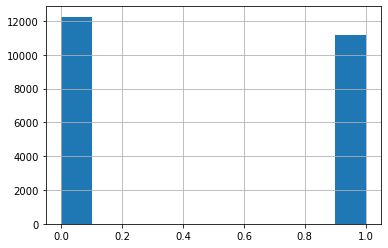

In [61]:
ax[3] = df_fin[df_fin['no_miss_days']==1]['republican'].hist()

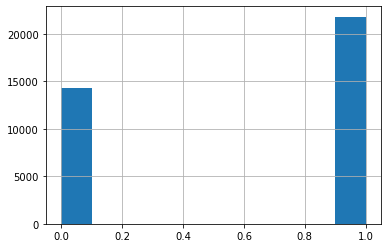

In [62]:
ax[2] = df_fin[df_fin['no_miss']==1]['republican'].hist()

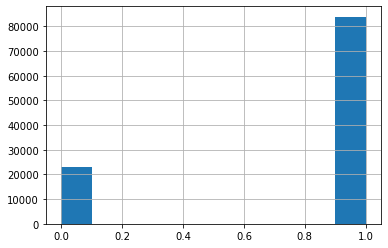

In [63]:
ax[1] = df_fin[df_fin['all_days']==1]['republican'].hist()